# Analysis of Cross-Sectional Data

## Machine Learning Approaches to Regression

### Kevin Sheppard

In [1]:
import os
import pickle
from itertools import combinations

import matplotlib.pyplot as plt
import mfe
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pandas.plotting import scatter_matrix as pd_scatter_matrix
from scipy import stats
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor, plot_tree


mfe.full_setup()
mfe.outputs["pres"]()
DEFAULT_FIGSIZE = (32, 15)
plt.rc("figure", figsize=DEFAULT_FIGSIZE)
plt.rc("font", size=48)
factors = pd.read_hdf("data/fama-data.h5", "factors").resample("M").last()
ports = pd.read_hdf("data/fama-data.h5", "portfolios").resample("M").last()

data = pd.concat([factors, ports], axis=1)
data = data.resample("M").last().dropna()
vwm = data["$VWM^e$"]
size = data["$SMB$"]
industries = ports.iloc[:, 6:]
industries.std()

gen = np.random.default_rng(392018402378423749023742390)
state = gen._bit_generator.state


def random_gen():
    new_gen = np.random.default_rng()
    gen._bit_generator.state = state
    return gen


def forward_stepwise_regression(lhs, rhs, required=None, constant=True):
    n, p = rhs.shape
    base = []
    best = {}
    opt_sse = {}

    if constant:
        assert "constant" not in rhs
        const = pd.Series(np.ones(n), name="constant", index=lhs.index)
        rhs = pd.concat([const, rhs], axis=1)
        base += ["constant"]

    if required is not None:
        rhs = pd.concat([required, rhs], axis=1)
        base += list(rhs.columns)
    if base:
        best[len(base)] = base[:]
        opt_sse[len(base)] = (sm.OLS(lhs, rhs[base]).fit().resid ** 2).sum()
    start_col = int(constant)
    for i in range(p):
        sse = []
        if i == 0:
            start = base
        else:
            start = best[max(best.keys())]
        for col in rhs.iloc[:, start_col:]:
            reg = start[:]
            if col in reg:
                continue
            reg.append(col)
            sse.append((tuple(reg), (sm.OLS(lhs, rhs[reg]).fit().resid ** 2).sum()))
        sse = sorted(sse, key=lambda v: v[1])
        selected_reg = list(sse[0][0])
        best[len(selected_reg)] = selected_reg
        opt_sse[len(selected_reg)] = sse[0][1]
    return best, opt_sse


def backward_stepwise_regression(lhs, rhs, constant=True):
    n, p = rhs.shape
    if constant:
        assert "constant" not in rhs
        const = pd.Series(np.ones(n), name="constant", index=lhs.index)
        rhs = pd.concat([const, rhs], axis=1)
    base = list(rhs.columns)
    best = {rhs.shape[1]: base}
    opt_sse = {rhs.shape[1]: (sm.OLS(lhs, rhs).fit().resid ** 2).sum()}

    while len(base) > 1:
        sse = []
        removal_candidates = [col for col in rhs if col in base and col != "constant"]
        for col in removal_candidates:
            reg = base[:]
            reg.remove(col)
            sse.append((tuple(reg), (sm.OLS(lhs, rhs[reg]).fit().resid ** 2).sum()))
        sse = sorted(sse, key=lambda v: v[1])
        best[len(reg)] = list(sse[0][0])
        opt_sse[len(reg)] = sse[0][1]
        base = best[len(reg)][:]
    return best, opt_sse


def k_fold_xval(lhs, rhs, gen, k=5):
    n, p = rhs.shape

    idx = gen.choice(n, size=n, replace=False)
    errors = lhs.copy()
    m = n / k
    for i in range(k):
        start = int(np.round(i * m))
        end = int(np.round((i + 1) * m))
        excl = idx[start:end]
        incl = np.r_[idx[:start], idx[end:]]
        beta = sm.OLS(lhs.iloc[incl], rhs.iloc[incl]).fit().params
        errors.iloc[excl] = lhs.iloc[excl] - sm.OLS(
            lhs.iloc[excl], rhs.iloc[excl]
        ).predict(beta)
    return (errors ** 2).sum()


def k_fold_xval_many(models, lhs, rhs, gen, constant=True):
    state = gen._bit_generator.state
    xv_sses = {}
    if constant:
        assert "constant" not in rhs
        n = lhs.shape[0]
        const = pd.Series(np.ones(n), name="constant", index=lhs.index)
        rhs = pd.concat([const, rhs], axis=1)
    for key in models:
        xv_sses[key] = k_fold_xval(lhs, rhs[models[key]], gen)
    gen._bit_generator.state = state
    return xv_sses


def forward_backward(lhs, rhs, required=None, constant=True):
    models, _ = forward_stepwise_regression(
        lhs, rhs, required=required, constant=constant
    )
    final = set([tuple(models[key]) for key in models])
    for model in models:
        if model > 2:
            base = models[model]
            if "constant" in base:
                base.remove("constant")
            submods, _ = backward_stepwise_regression(lhs, rhs[base], constant=constant)
            new = [tuple(submods[key]) for key in submods]
            final.update([tuple(submods[key]) for key in submods])
    models = dict((i, list(val)) for i, val in enumerate(final))
    sses = {}
    if constant:
        assert "constant" not in rhs
        const = pd.Series(np.ones(lhs.shape[0]), name="constant", index=lhs.index)
        rhs = pd.concat([const, rhs], axis=1)

    for key in models:
        sses[key] = (sm.OLS(lhs, rhs[models[key]]).fit().resid ** 2).sum()
    return models, sses


rg = np.random.default_rng(984309857902750752763452098347823679)
iloc = rg.choice(industries.shape[1], size=15, replace=False)


def best_subset_regression(lhs, rhs, constant=True):
    n, p = rhs.shape
    base = []
    best_subset = {}
    best_sse = {}
    rhs_names = list(rhs.columns)
    if constant:
        assert "constant" not in rhs
        const = pd.Series(np.ones(n), name="constant", index=lhs.index)
        rhs = pd.concat([const, rhs], axis=1)
        base += ["constant"]
        best_subset[1] = ["constant"]
        best_sse[1] = ((lhs - lhs.mean()) ** 2).sum()

    for i in range(1, p + 1):
        min_sse = np.inf
        for comb in combinations(rhs_names, i):
            reg = base + list(comb)
            sse = (sm.OLS(lhs, rhs[reg]).fit().resid ** 2).sum()
            if sse < min_sse:
                min_sse = sse
                best_subset[len(reg)] = reg
                best_sse[len(reg)] = sse
    return best_subset, best_sse


def xval_plot(sse, sse_xv, k=None):
    sse = pd.Series(sse).sort_index()
    sse_xv = pd.Series(sse_xv).sort_index()
    if k is None:
        k = np.arange(1, sse.shape[0] + 1)
    else:
        k = np.asarray(k)
    order = np.argsort(k)
    sse = sse.iloc[order]
    sse_xv = sse_xv.iloc[order]
    k = k[order]
    fig, ax = plt.subplots(1, 1)
    ratio = np.log(sse / sse_xv)
    temp = pd.DataFrame({"ratio": ratio, "k": pd.Series(k, index=ratio.index)})
    ratio = temp.groupby("k").ratio.mean()
    vc = temp.k.value_counts()
    vc = vc.loc[vc > 1]
    ax.plot(np.asarray(ratio.index), ratio, linewidth=5, label="Ratio")
    if vc.shape[0]:
        loc = temp.k.isin(vc.index)
        ax.plot(
            temp.k.loc[loc],
            temp.ratio.loc[loc],
            marker="D",
            markersize=18,
            alpha=0.33,
            linewidth=0,
            color=mfe.colors[0],
        )
    ax.set_ylabel("Ratio $\\ln(\\text{SSE}/\\text{SSE}_{xv})$")
    ax.set_xticks(ratio.index)
    plt.xticks(rotation=90)
    ax2 = ax.twinx()
    df2 = pd.DataFrame({"k": k, "SSE$_{xv}$": sse_xv})
    min_by_k = df2.groupby("k")["SSE$_{xv}$"].min()
    retain = min_by_k < (np.exp(0.25) * min_by_k.min())
    _kx = min_by_k.loc[retain].index
    _ky = np.log(min_by_k.loc[retain])
    best_loc = np.argmin(_ky)
    reject = np.setdiff1d(np.arange(_kx.shape[0]), [best_loc])
    ax2.plot(
        _kx[reject],
        _ky.iloc[reject],
        color=mfe.colors[3],
        linewidth=0,
        marker="X",
        markersize=24,
        label="Suboptimal SSE$_{xv}$",
    )
    ax2.plot(
        _kx[[best_loc]],
        _ky.iloc[[best_loc]],
        color=mfe.colors[2],
        linewidth=0,
        marker="o",
        markersize=18,
        label="Optimal SSE$_{xv}$",
    )
    ax2.set_ylabel("$\ln(\\text{SSE}_{xv})$")
    ax.set_xlim(k[0] - 0.33, k.max() + 0.33)
    plt.legend(frameon=False, loc="lower left")
    fig.tight_layout(pad=1.0)
    ax.set_xlabel("Model size $k$")


selected_industries = industries.iloc[:, iloc]
mfe.figsize(y=14)

# Analysis of Cross-Sectional Data
## Best Subset Regression and Stepwise Regression

* Best Subset Regression
* Forward Stepwise Regression
* Backward Stepwise Regression
* Hybrid Stepwise Regression


# Best Subset Regression

* With $p$ candidate variables, consider all $2^p$ possible models
* For each $k=1,\ldots,p$ find the best model in terms of $SSE$
* From set of $p$ best models, select preferred model using cross-validation
* Example regression is portfolio tracking/replication

$$ VWM_t = \sum_{i=1}^k \beta_i R_{i,t} + \epsilon_t$$

* $R_{i,t}$ are industry portfolio returns
* BSR example uses 15 randomly selected industry portfolios due to computational limits

In [2]:
bsr_models, bsr_sse = best_subset_regression(vwm, selected_industries, constant=False)
bsr_sse_xv = k_fold_xval_many(
    bsr_models, vwm, selected_industries, random_gen(), constant=False
)

# Best Subset Regression

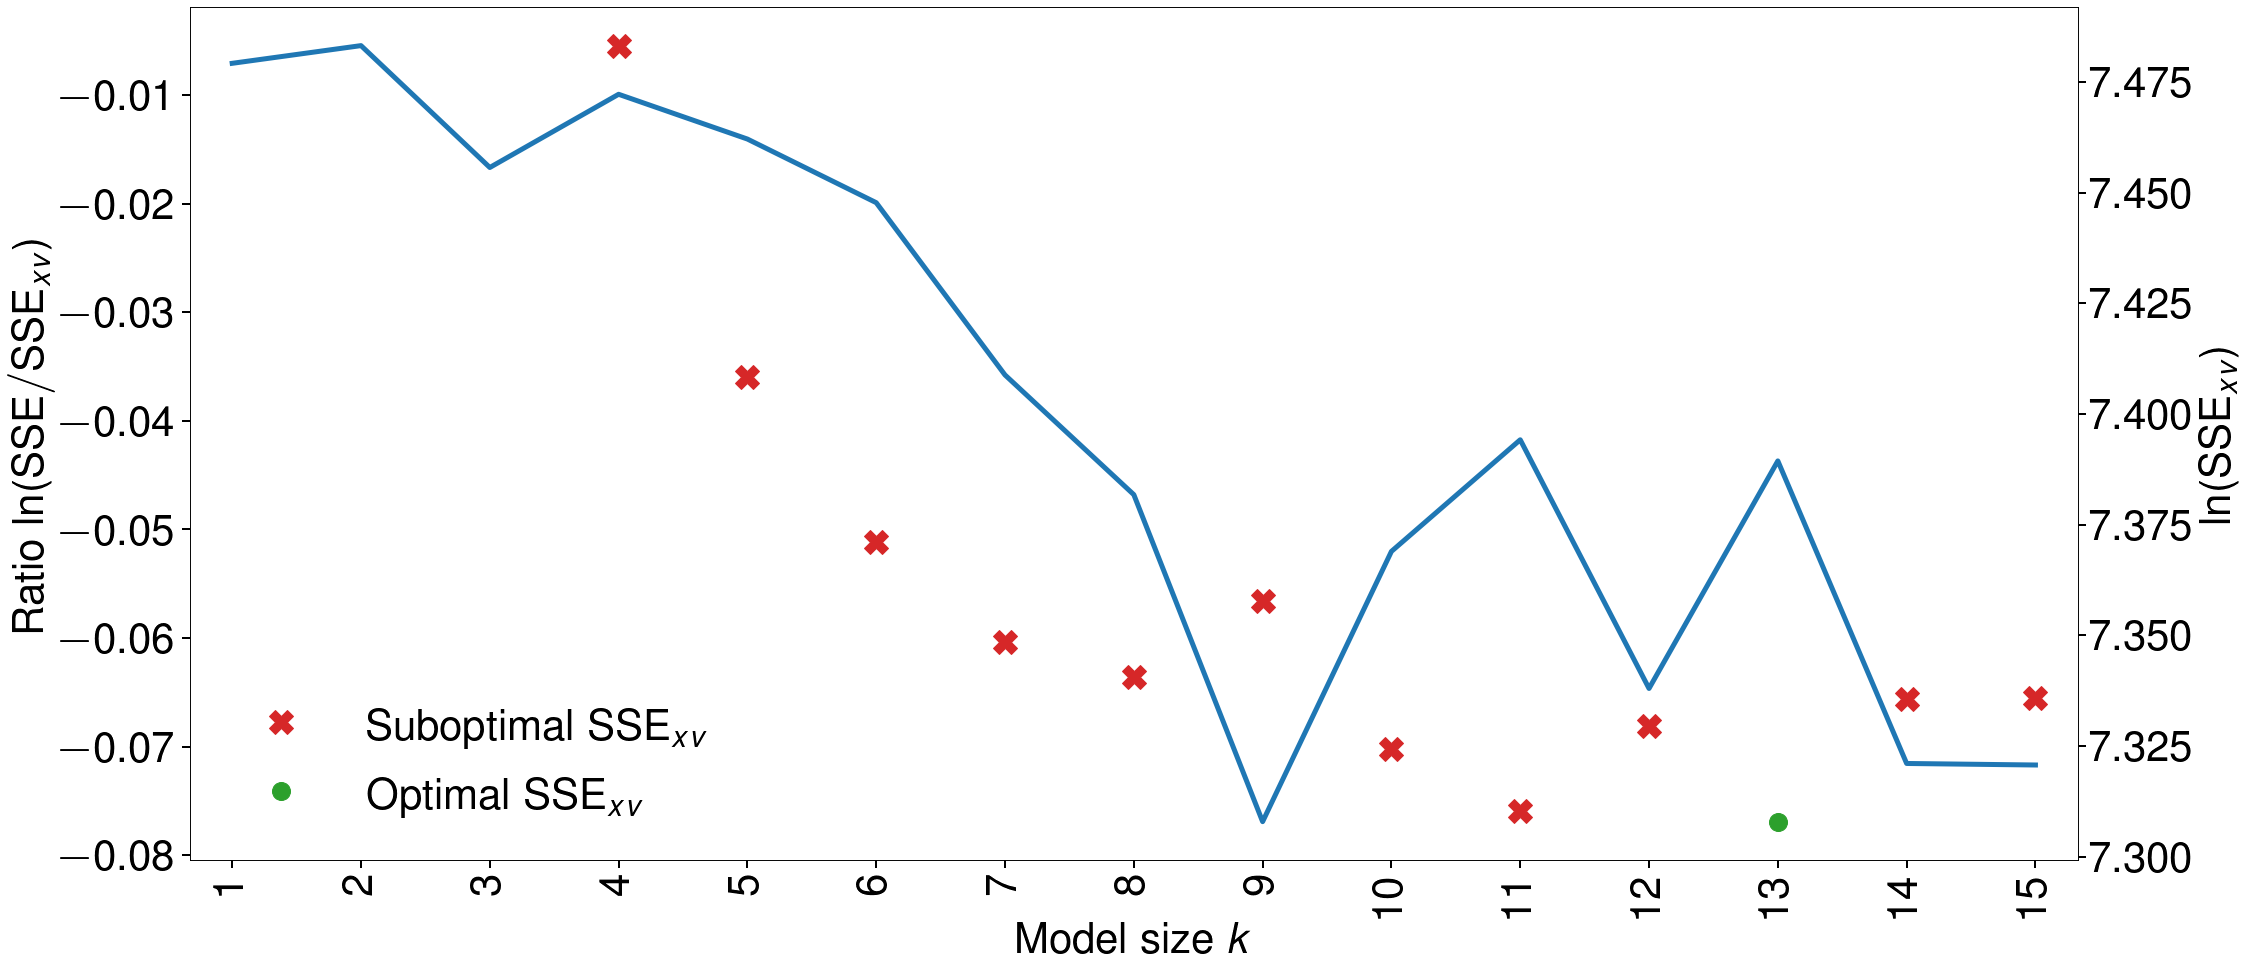

In [3]:
xval_plot(bsr_sse, bsr_sse_xv)

In [4]:
fs_models, fs_sse = forward_stepwise_regression(vwm, industries, constant=False)
fs_sse_xv = k_fold_xval_many(fs_models, vwm, industries, random_gen())

# Forward Stepwise Regression

* When $p$ is large Best Subset Regression is computationally impossible
* Forward Stepwise Regression builds a sequence of models using two principles
    1. Start from the previous model with $i$ variables
    2. Considering all excluded variables, **add** the variable to model $i+1$ that produces the **largest reduction in SSE**
* Begins with model $0$ that includes no variables (or possibly a constant)
* Produces a sequence of $p$ (or $p+1$ if a constant) models
* Preferred model is selected from these models using cross-validated SSE

# Forward Stepwise Regression

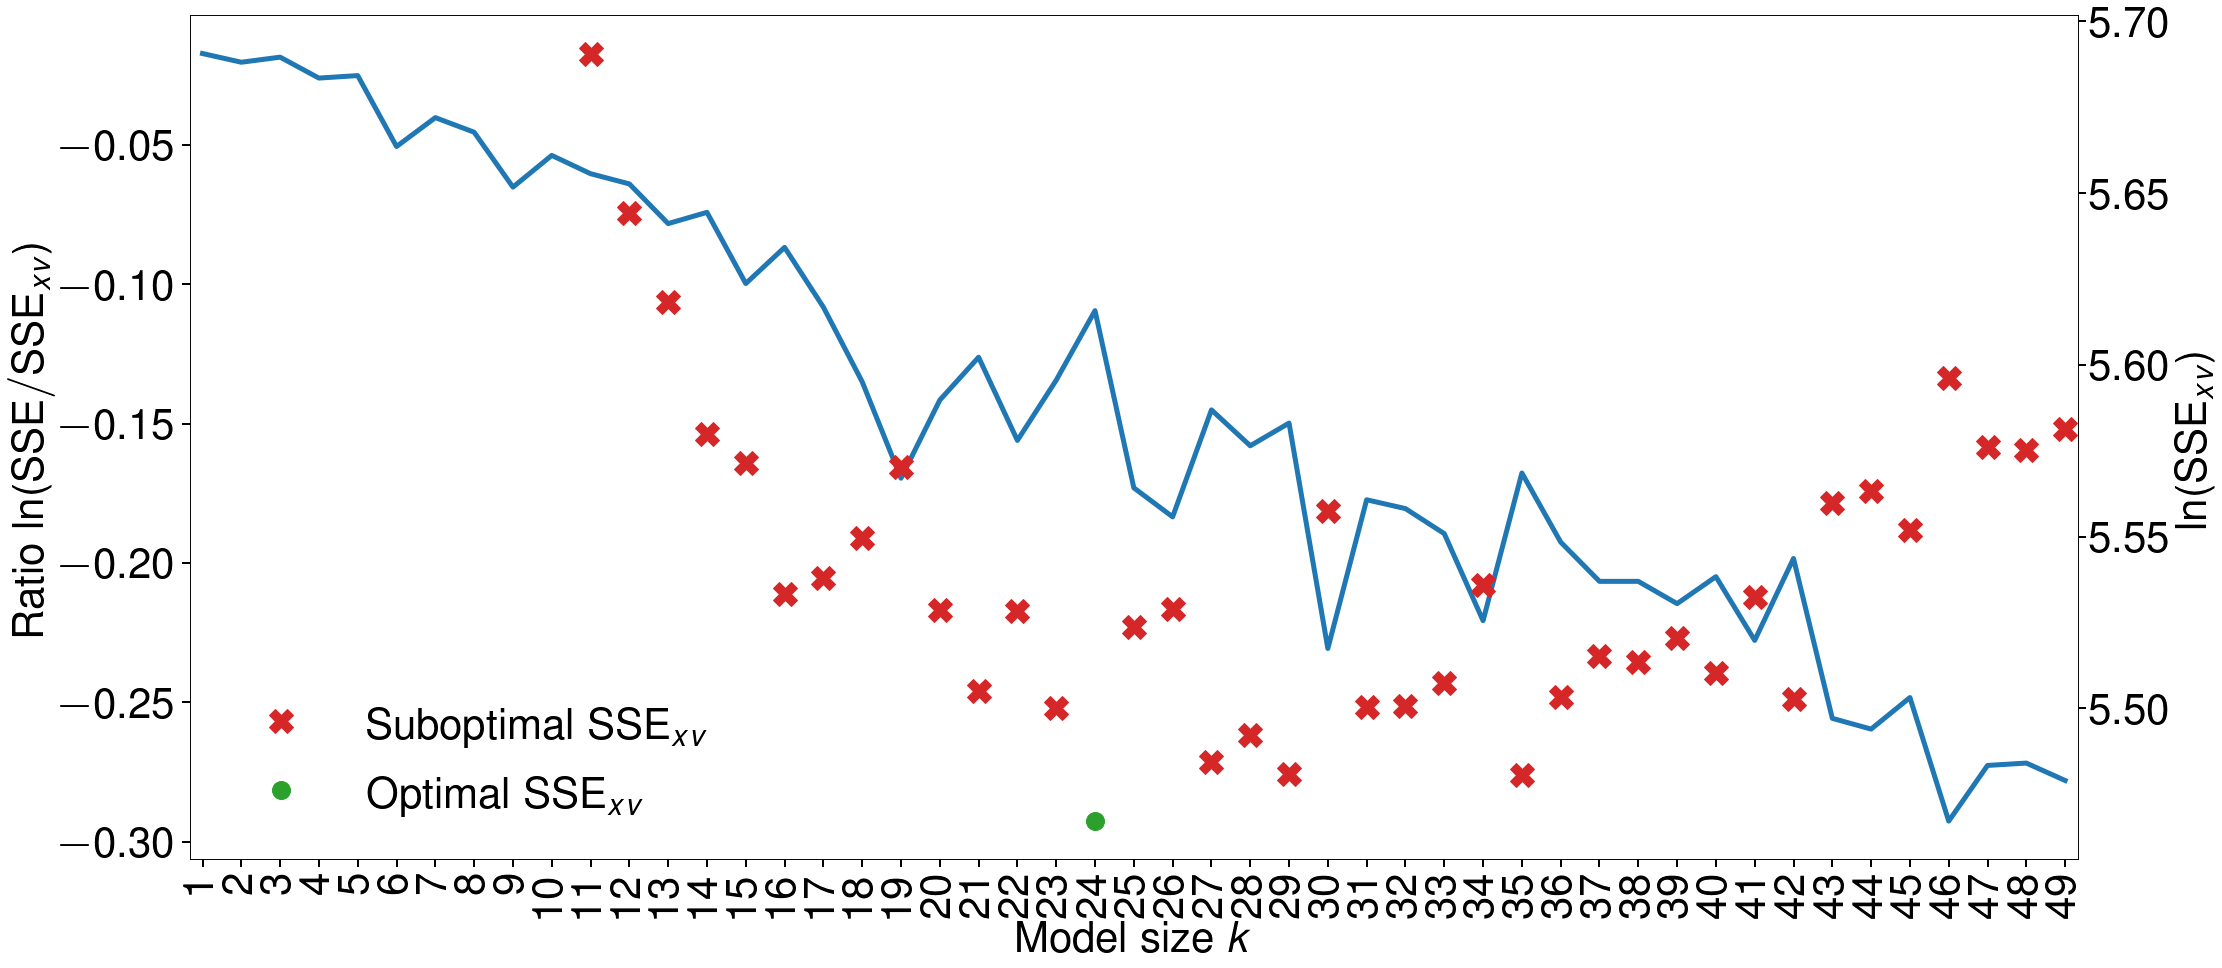

In [5]:
xval_plot(fs_sse, fs_sse_xv)

In [6]:
bs_models, bs_sse = backward_stepwise_regression(vwm, industries, constant=False)
bs_sse_xv = k_fold_xval_many(bs_models, vwm, industries, random_gen())

# Backward Stepwise Regression


* Similar to Forward Stepwise only constructed by _removing_ variables
* Backward Stepwise Regression builds a sequence of models using two principles
    1. Start from the previous model with $i$ variables
    2. Considering all included variables in model $i$, **remove** the variable that **increases the SSE the least** to construct model $i-1$
* Begins with model $p$ that includes all variables
* Like FSR, produces a sequence of $p$ (or $p+1$ if a constant) models
* Preferred model is selected from these models using cross-validated SSE

# Backward Stepwise Regression

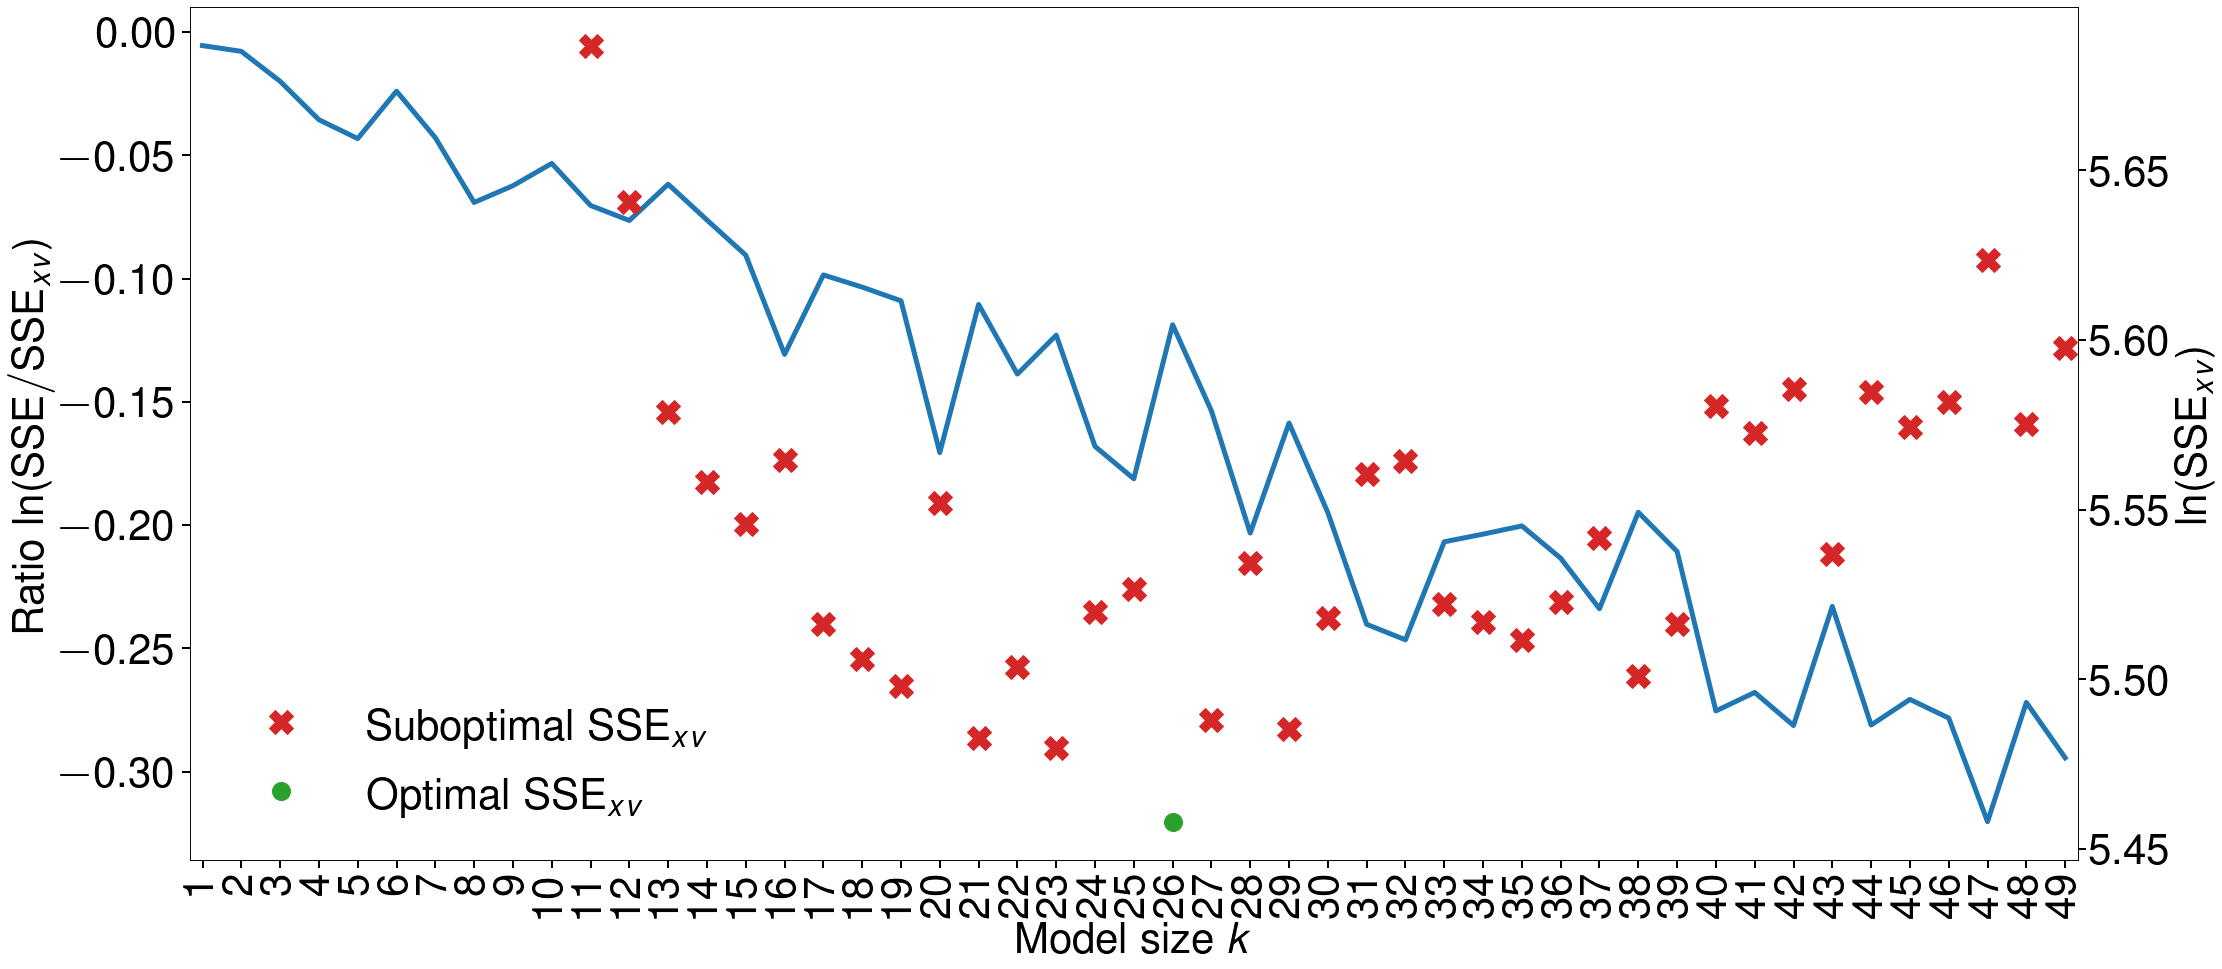

In [7]:
xval_plot(bs_sse, bs_sse_xv)

# Comparing Forward and Backward Stepwise Regression

In [8]:
fs_model = fs_models[pd.Series(fs_sse_xv).idxmin()]
bs_model = bs_models[pd.Series(bs_sse_xv).idxmin()]
print(f"Number of common regressors: {len(set(bs_model).intersection(fs_model))}")
print(f"Only in FS: {', '.join(sorted(set(fs_model).difference(bs_model)))}")
print(f"Only in BS: {', '.join(sorted(set(bs_model).difference(fs_model)))}")

Number of common regressors: 23
Only in FS: Mach
Only in BS: Coal, Fun, Meals


# Hybrid Approaches

* Forward and Backward can be combined to produce a larger set of candidate models
* Forward-Backward
    * Use FSR to build select candidate models with $k=1,\ldots,p$ variables
    * Starting with each of these $p$ model, perform Backward Stepwise
* Can be iterated as much as one is willing to wait
* Might better approximate Best Subset Regression
* Final model selected from enlarged set of candidate models by minimizing the cross-validated SSE

In [9]:
fb_models, fb_sse = forward_backward(vwm, industries, constant=False)
fb_sse_xv = k_fold_xval_many(fb_models, vwm, industries, gen)
fb_model = fb_models[pd.Series(fb_sse_xv).idxmin()]
fb_k = pd.Series([len(fb_models[key]) for key in fb_models])

In [10]:
print(f"The number of models selected using forward-backward is {len(fb_models)}")
print(f"Not in FS: {', '.join(sorted(set(fb_model).difference(fs_model)))}")
print(f"Not in BS: {', '.join(sorted(set(fb_model).difference(bs_model)))}")

The number of models selected using forward-backward is 117
Not in FS: 
Not in BS: 


# Hybrid Approaches

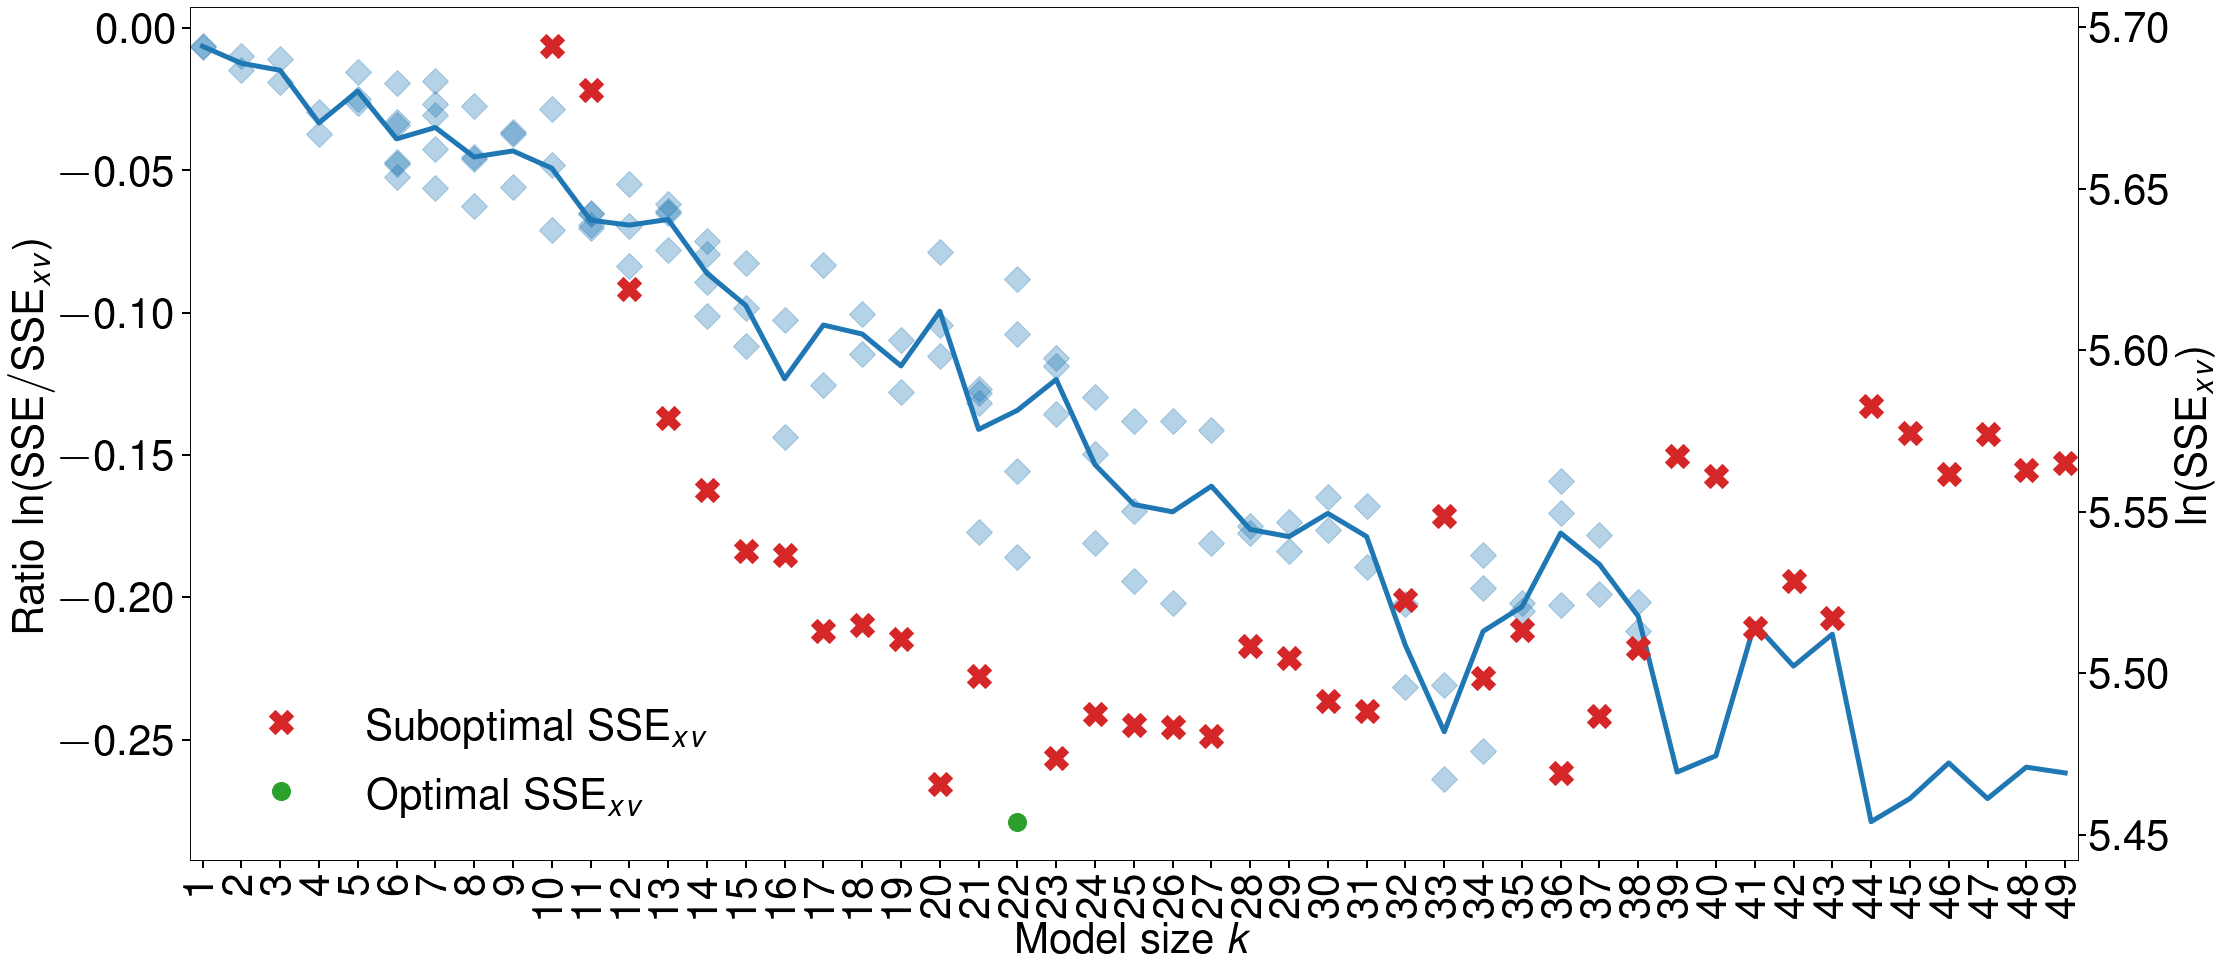

In [11]:
xval_plot(fb_sse, fb_sse_xv, k=fb_k)

# Analysis of Cross-Sectional Data
## Shrinkage Estimators

* Ridge Regression
* LASSO: Least Absolute Shrinkage and Selection Operator

**Note**: Important to standardized regressors when using shrinkage estimators

# Ridge Regression

Fit a modified least squares problem

$$
\arg\!\min_{\boldsymbol{\beta}}\,\left(\mathbf{y}-\mathbf{X}\boldsymbol{\beta}\right)^{\prime}\left(\mathbf{y}-\mathbf{X}\boldsymbol{\beta}\right)\text{ subject to }\sum_{j=1}^{k}\beta_{j}^{2}\leq\omega
$$

Equivalent formulation

$$ \arg\!\min_{\boldsymbol{\beta}}\,\left(\mathbf{y}-\mathbf{X}\boldsymbol{\beta}\right)^{\prime}\left(\mathbf{y}-\mathbf{X}\boldsymbol{\beta}\right)+\lambda\sum_{j=1}^{k}\beta_{j}^{2}$$

Analytical solution

$$\hat{\boldsymbol{\beta}}^{\textrm{Ridge}}=\left(\mathbf{X}^{\prime}\mathbf{X}+\lambda \mathbf{I}_{k}\right)^{-1}\mathbf{X}^{\prime}\mathbf{y}$$

* $\lambda$ is key shrinkage (ore regularization) parameter
* Optimal $\lambda$ is chosen using cross-validations across a grid of values

In [12]:
ss = StandardScaler(with_mean=False).fit(industries)
std_industries = ss.transform(industries)
ss_vwm = StandardScaler(with_mean=False).fit(vwm.to_numpy()[:, None])
std_vwm = ss_vwm.transform(vwm.to_numpy()[:, None])

alphas = np.linspace(1, 100, 1001)
ridge_cv = RidgeCV(fit_intercept=False, alphas=alphas, store_cv_values=True).fit(
    std_industries, std_vwm
)


def ridge_cv_plot():
    fig, ax = plt.subplots(1, 1)
    cv = np.squeeze(ridge_cv.cv_values_.sum(0))
    loc = np.argmin(cv)
    ax.plot(alphas, cv)
    ax.plot(alphas[loc], cv[loc], marker="o", color=mfe.colors[2], markersize=36)
    ax.set_xlabel(r"$\alpha$")
    ax.set_ylabel("SSE$_{xv}$")
    ax.text(
        alphas[loc - 45], 1.003 * cv[loc], r"$\hat{\alpha}=" + f"{alphas[loc]:0.2f}$"
    )


def ridge_coef_plot():
    beta = sm.OLS(std_vwm, std_industries).fit().params
    ridge_beta = np.squeeze(ridge_cv.coef_)
    coef = pd.DataFrame(beta, columns=["OLS"])
    coef["Ridge"] = ridge_beta
    fig, ax = plt.subplots(1, 1)
    coef.plot.bar(ax=ax, legend=False)
    ax.set_xticks([])
    ax.legend(frameon=False)
    fig.tight_layout(pad=1.0)

# Ridge Regression $\alpha$ Selection

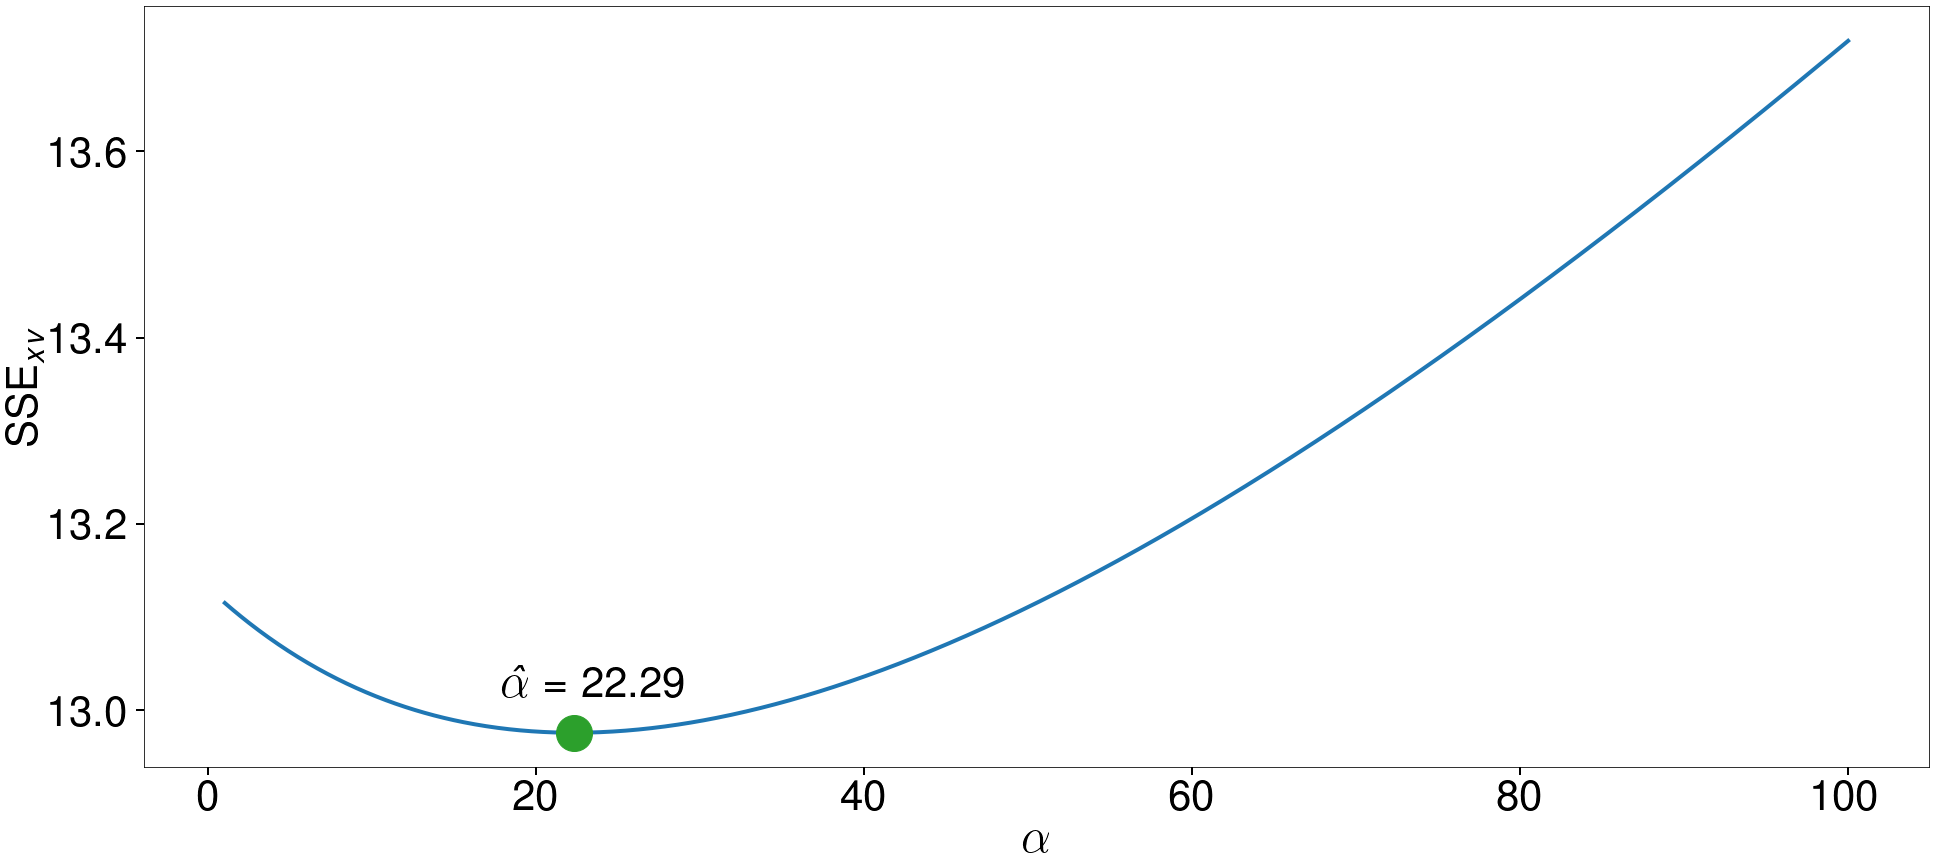

In [13]:
ridge_cv_plot()

# Ridge Regression

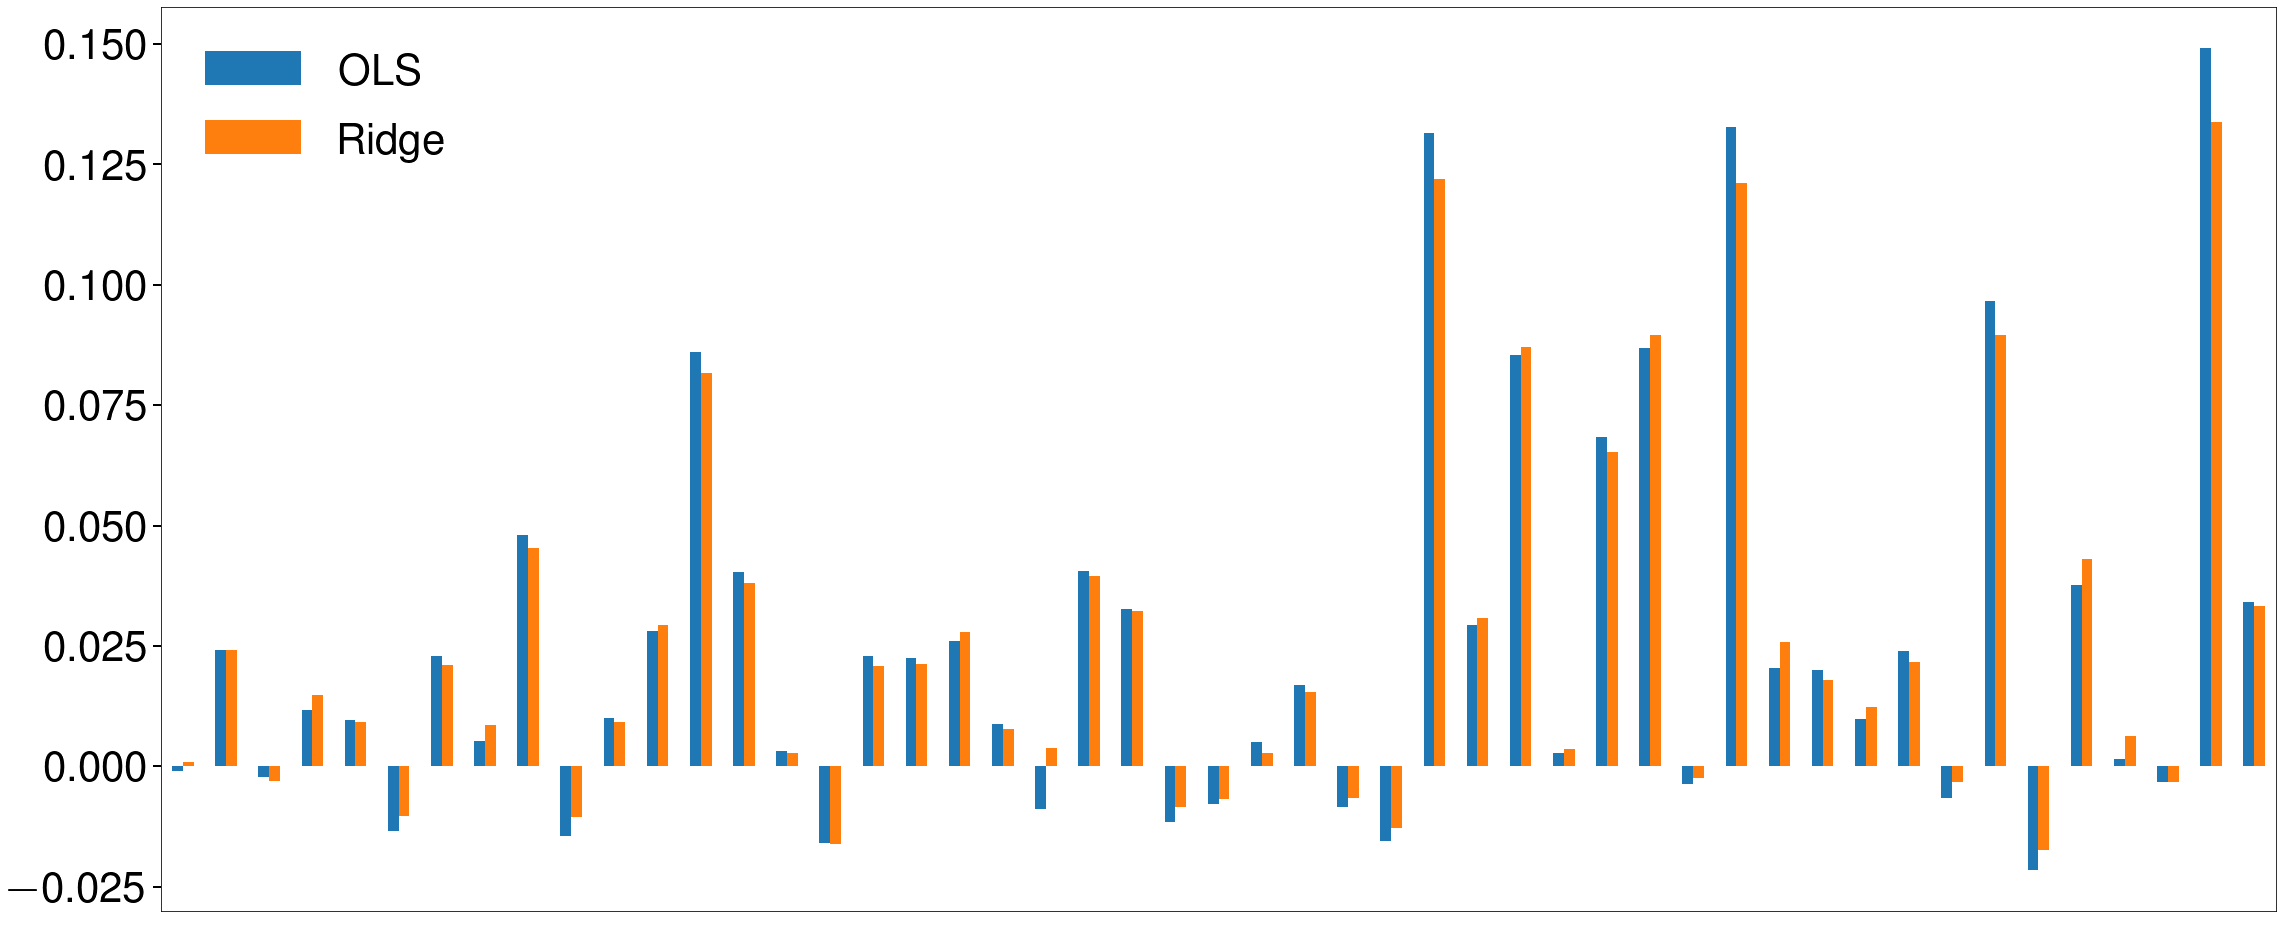

In [14]:
ridge_coef_plot()

In [15]:
lcv = LassoCV(alphas=np.linspace(0.001, 0.1, 2001), fit_intercept=False).fit(
    std_industries, np.squeeze(std_vwm)
)


def lasso_cv_plot():
    fig, ax = plt.subplots(1, 1)
    alphas, cv = lcv.alphas_, lcv.mse_path_.sum(1)
    loc = np.argmin(cv)
    ax.plot(alphas, cv)
    ax.plot(alphas[loc], cv[loc], marker="o", color=mfe.colors[2], markersize=36)
    ax.set_xlabel(r"$\alpha$")
    ax.set_ylabel("SSE$_{xv}$")
    ax.text(
        alphas[loc + 20], 1.08 * cv[loc], r"$\hat{\alpha}=" + f"{alphas[loc]:0.3f}$"
    )


def lasso_coef_plot():
    beta = sm.OLS(std_vwm, std_industries).fit().params
    lasso_beta = lcv.coef_
    loc = np.abs(lasso_beta) < 0.001
    print(f"Number of non-zero coefficients: {(~loc).sum()}")
    coef = pd.DataFrame(beta, columns=["OLS"])
    coef["LASSO"] = lasso_beta
    fig, ax = plt.subplots(1, 1)
    coef.plot.bar(ax=ax, legend=False)
    ax.set_xticks([])
    ax.legend(frameon=False)
    fig.tight_layout(pad=1.0)

    _x = np.arange(loc.shape[0])[loc]
    _y = np.zeros_like(_x, dtype=float)
    ax.plot(_x + 0.2, _y, linewidth=0, marker="X", color=mfe.colors[3], markersize=24)


def lasso_path_plot():
    vals = {}
    for a in np.arange(1.0, 0.001, -0.001):
        lasso = Lasso(alpha=a).fit(std_industries, np.squeeze(std_vwm))
        vals[a] = lasso.coef_
        if (np.abs(lasso.coef_) > 0).sum() == 11:
            break

    df = pd.DataFrame(vals).T
    df.columns = industries.columns
    df = df.loc[:, (np.abs(df) > 0.001).any()]
    df.index = np.abs(df).sum(1)
    ax = df.plot(legend=False)
    ax.set_xlabel("$\omega$")
    ax.set_ylabel("$\\beta$")
    ax.set_ylim(ax.get_ylim()[0], 1.3 * ax.get_ylim()[1])
    ax.legend(ncol=5, frameon=False)
    ax.set_xlim(df.index.min(), df.index.max())
    fig = ax.get_figure()
    fig.tight_layout(pad=1.0)

# LASSO: Least Absolute Shrinkage and Selection Operator

Similar to Ridge but with a different penalty

$$
\arg\!\min_{\boldsymbol{\beta}}\,\left(\mathbf{y}-\mathbf{X}\boldsymbol{\beta}\right)^{\prime}\left(\mathbf{y}-\mathbf{X}\boldsymbol{\beta}\right)\text{ subject to }\sum_{j=1}^{k}\left|\beta_{j}\right|\leq\omega
$$

Equivalent formulation

$$ \arg\!\min_{\boldsymbol{\beta}}\,\left(\mathbf{y}-\mathbf{X}\boldsymbol{\beta}\right)^{\prime}\left(\mathbf{y}-\mathbf{X}\boldsymbol{\beta}\right)+\lambda\sum_{j=1}^{k}\left|\beta_{j}\right|$$

* Analytical solution but not easily presentable
* Has special property -- will usually estimate some coefficients to be **exactly** zero
* $\lambda$ is key shrinkage (ore regularization) parameter
* Optimal $\lambda$ is chosen using cross-validations across a grid of values

# LASSO $\alpha$ Selection

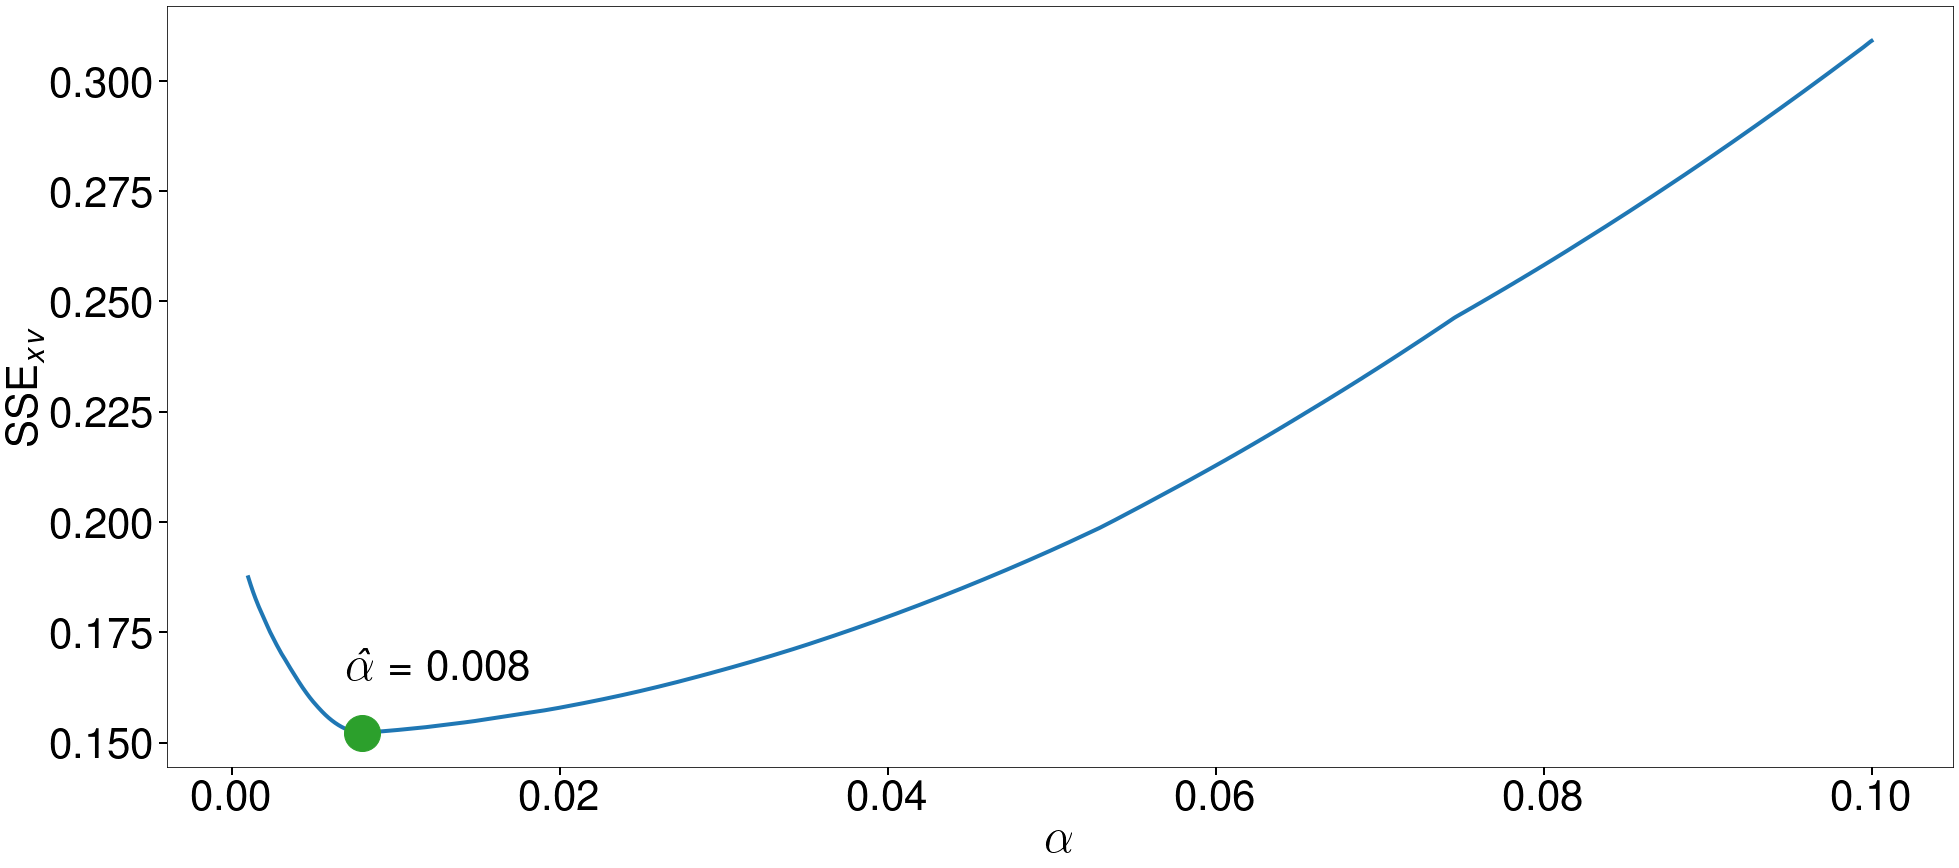

In [16]:
lasso_cv_plot()

# LASSO and OLS

In [17]:
mfe.figsize(y=12)

Number of non-zero coefficients: 30


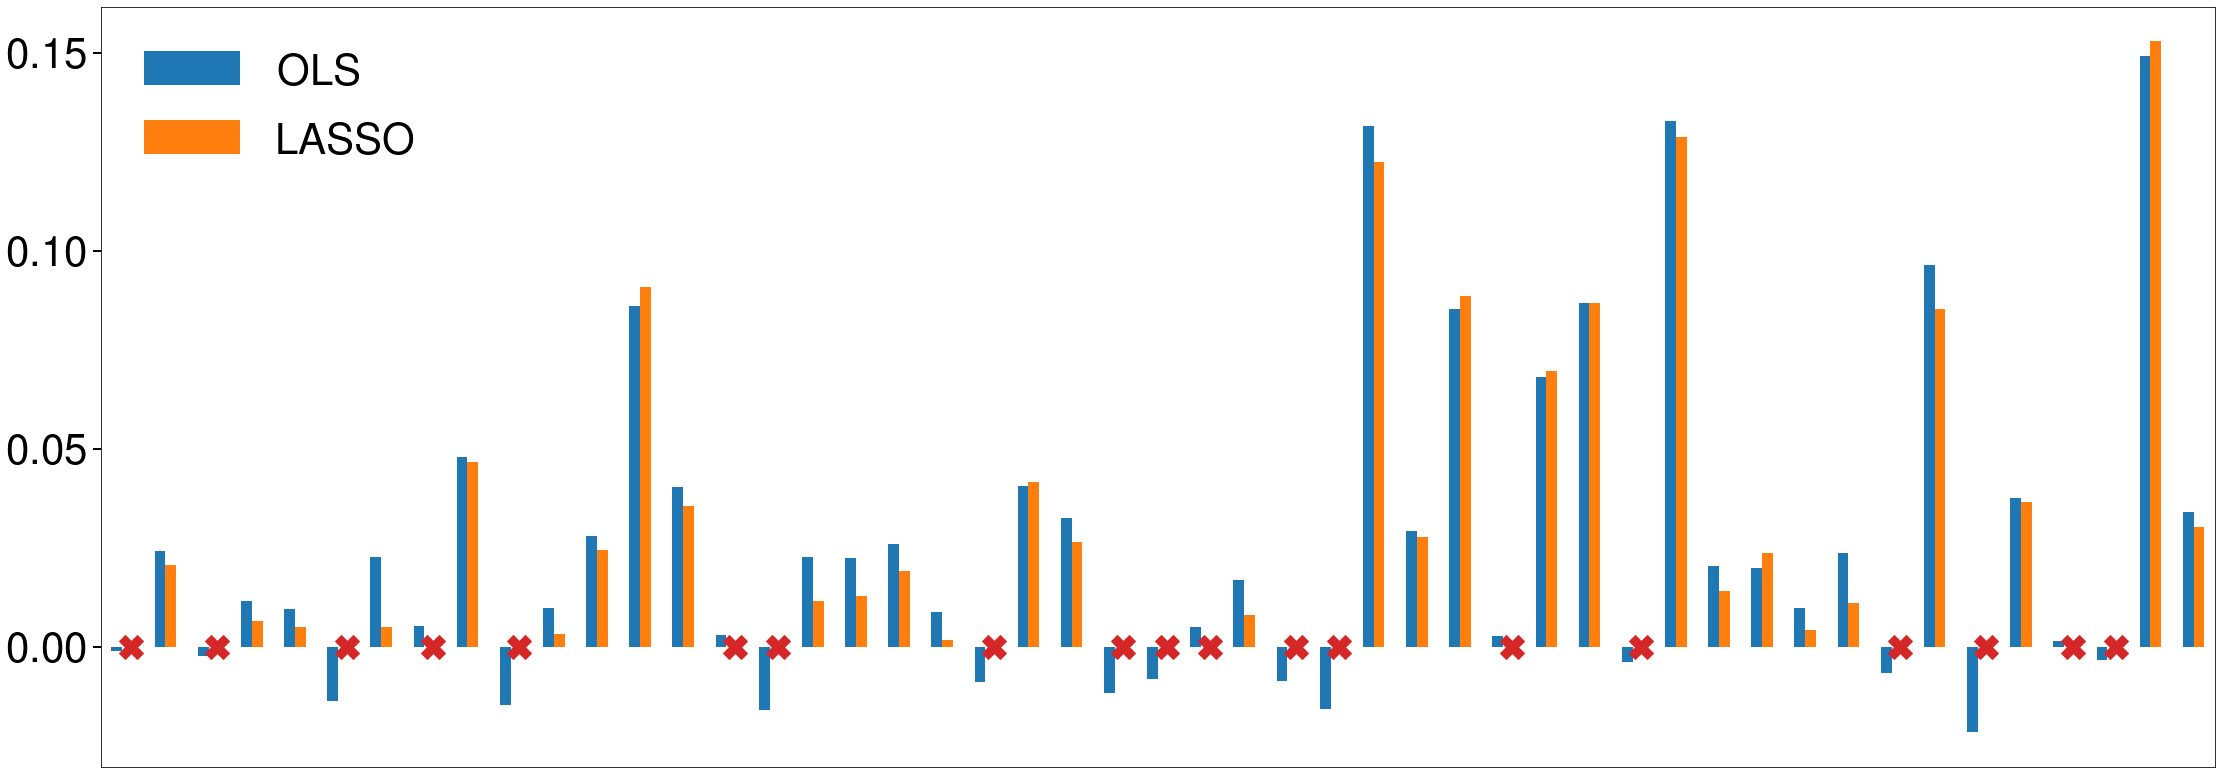

In [18]:
lasso_coef_plot()

# The LASSO Coefficient Path

In [19]:
mfe.figsize(y=14)

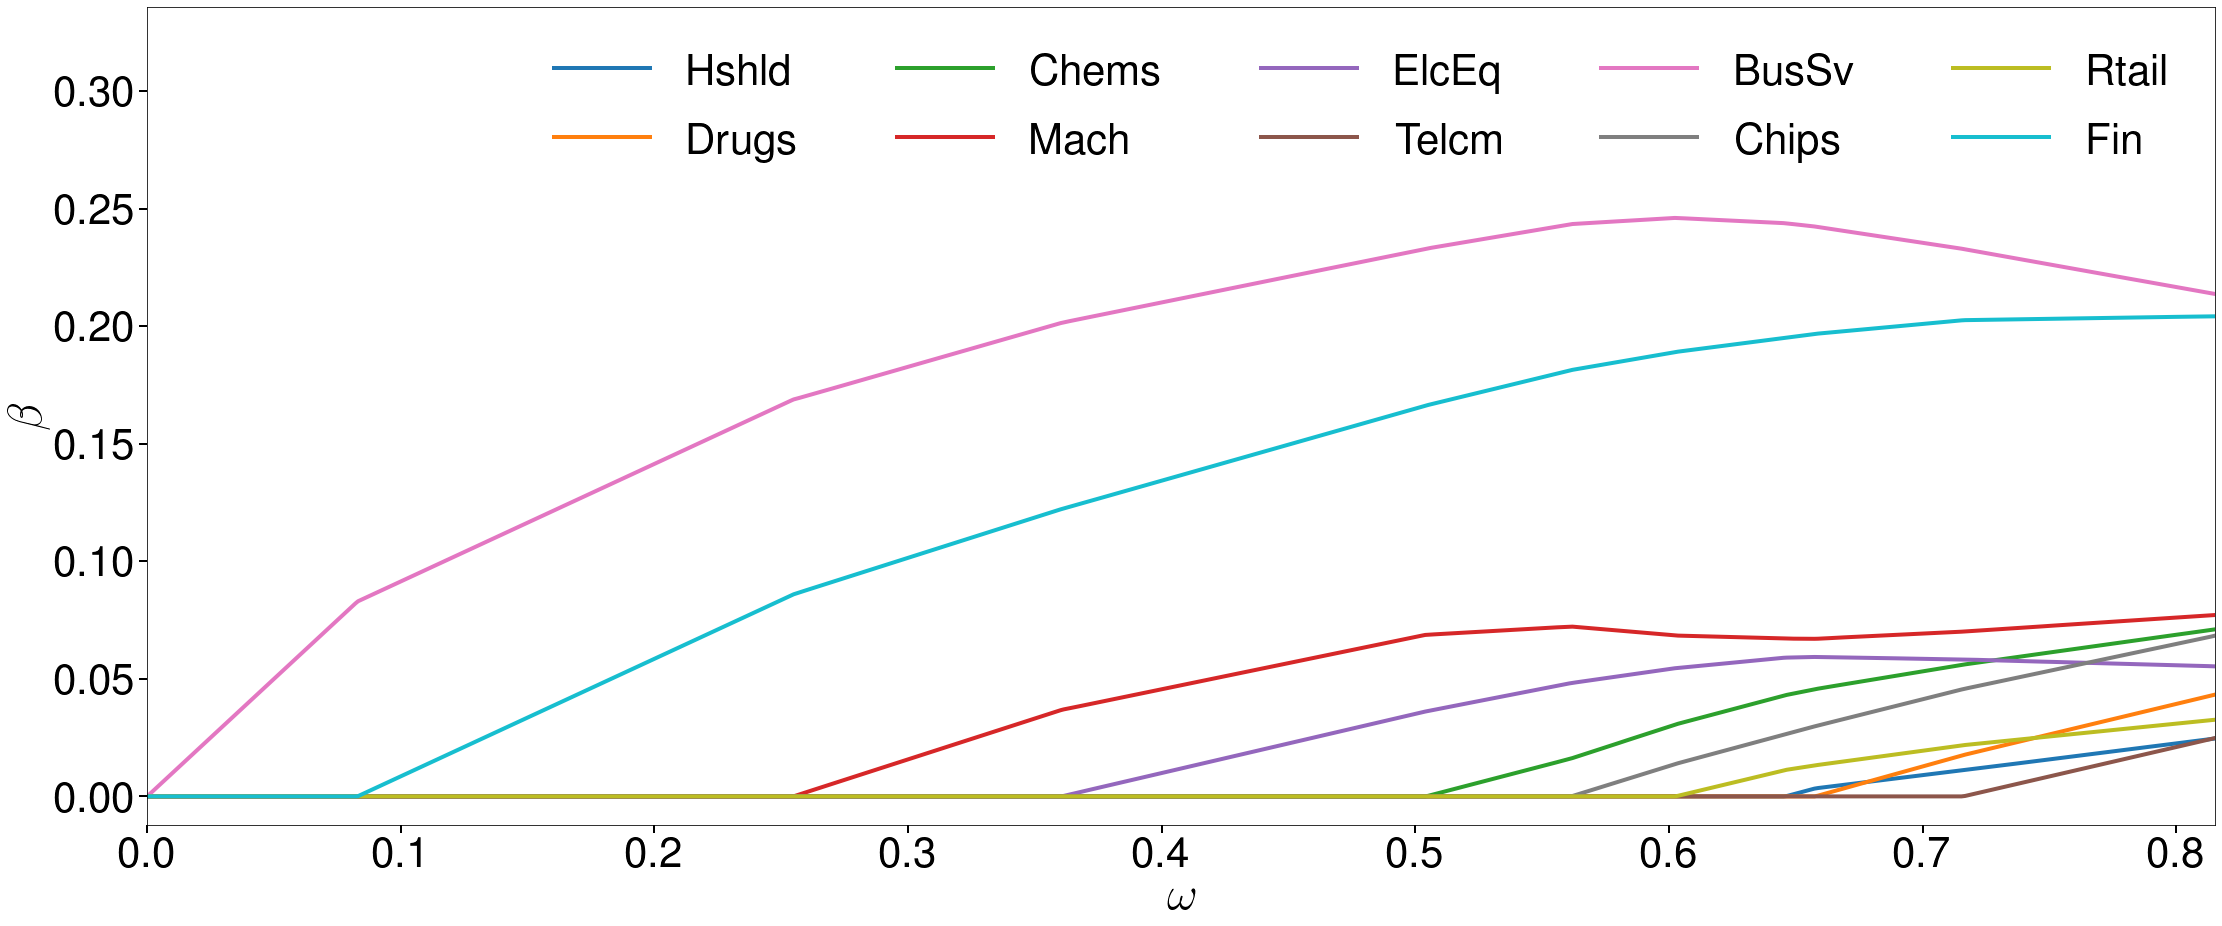

In [20]:
lasso_path_plot()

In [21]:
def ridge_betas():
    fig, ax = plt.subplots(3, 1)
    beta_total = 0.09910904742721603 * np.array([0.25, 0.5, 0.75]) / 1.25
    for i, alpha in enumerate((6000, 900, 275)):
        ridge = Ridge(alpha=alpha).fit(std_industries, std_vwm)
        ax[i].bar(np.arange(np.squeeze(ridge.coef_).shape[0]), np.squeeze(ridge.coef_))
        ax[i].set_ylim(0.0, 0.1)
        ax[i].set_xticks([])
        ax[i].set_title(fr"$\sum_{{i=1}}^k \beta^2={beta_total[i]:0.2f}$")
    fig.tight_layout(pad=1.0)


def lasso_betas():
    fig, ax = plt.subplots(3, 1)
    beta_total = [0.25, 0.5, 0.75]
    for i, alpha in enumerate((0.673, 0.46, 0.271)):
        lasso = Lasso(alpha=alpha).fit(std_industries, np.squeeze(std_vwm))
        ax[i].bar(np.arange(lasso.coef_.shape[0]), lasso.coef_)
        ax[i].set_ylim(0, 0.3)
        ax[i].set_xticks([])
        ax[i].set_title(fr"$\sum_{{i=1}}^k |\beta|={beta_total[i]}$")
    fig.tight_layout(pad=1.0)

# Alternative constraints in Ridge Regression

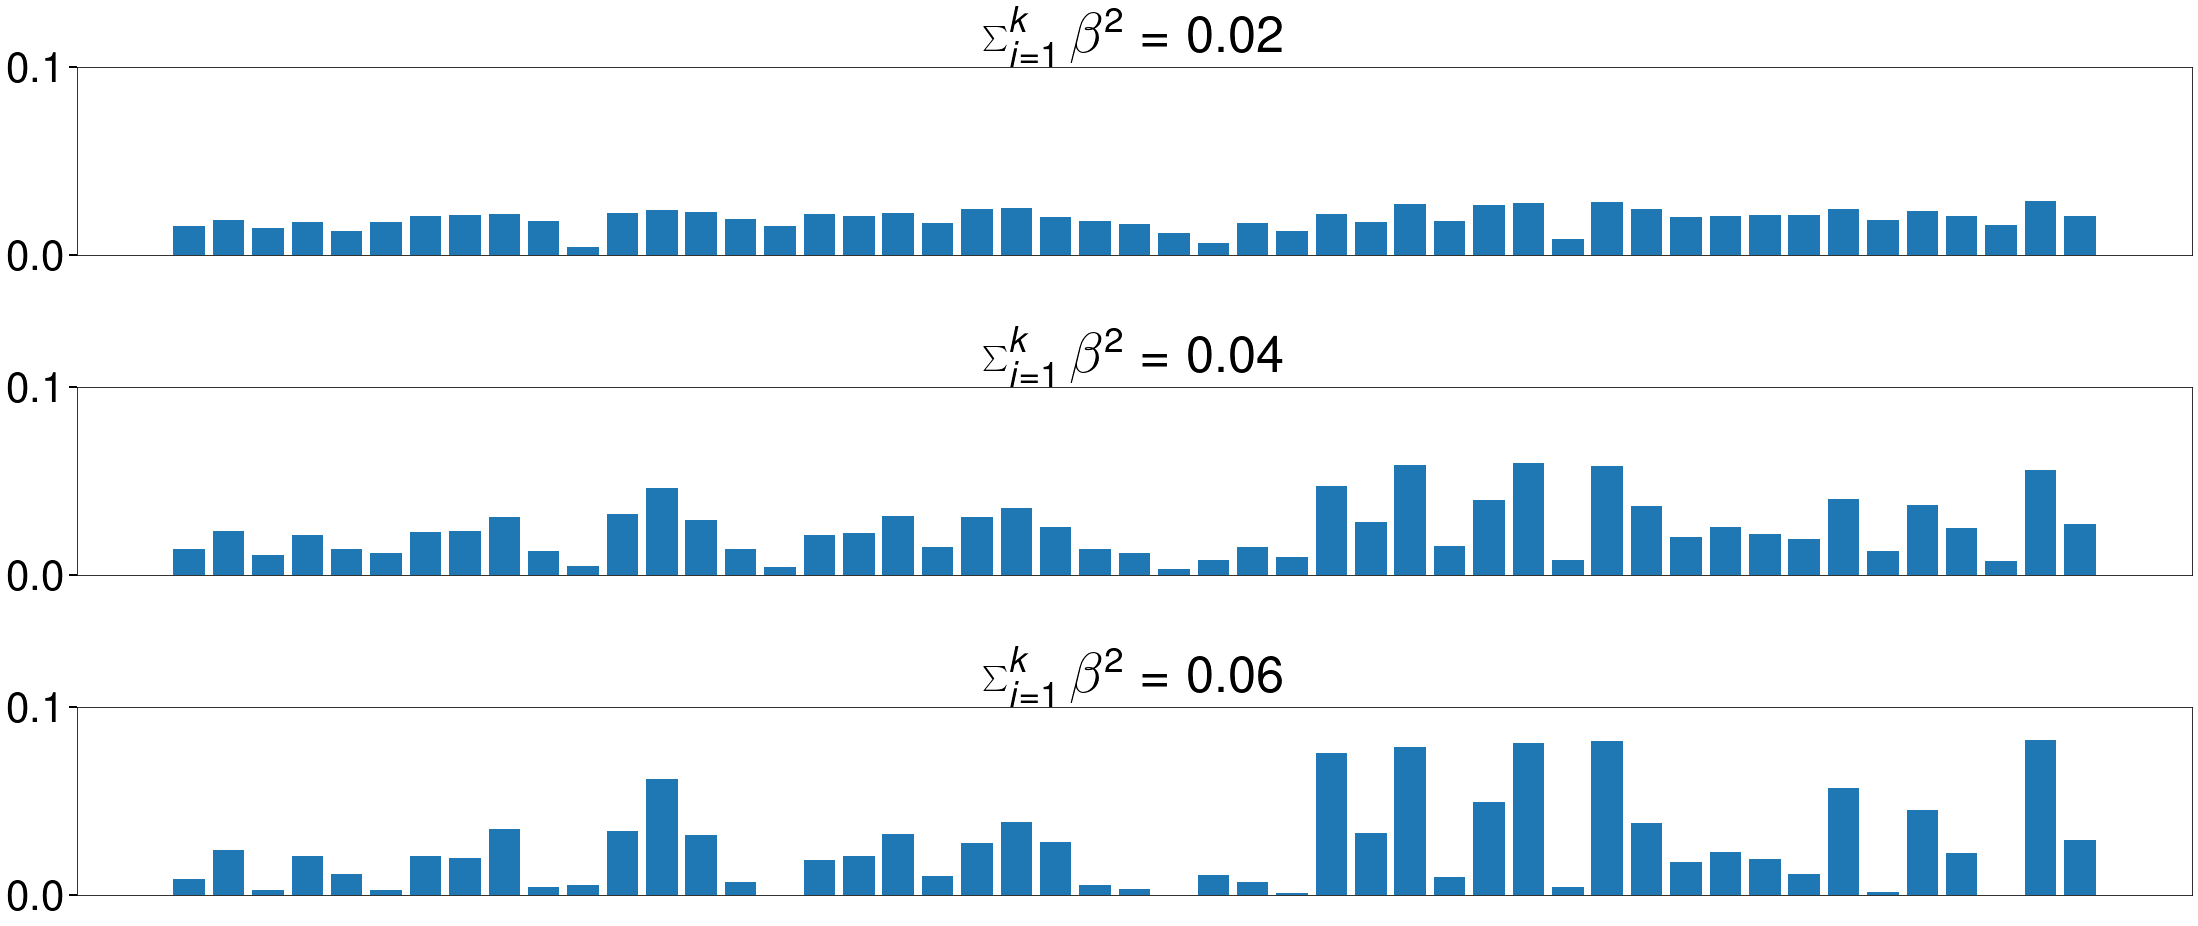

In [22]:
ridge_betas()

# Alternative constraints in LASSO

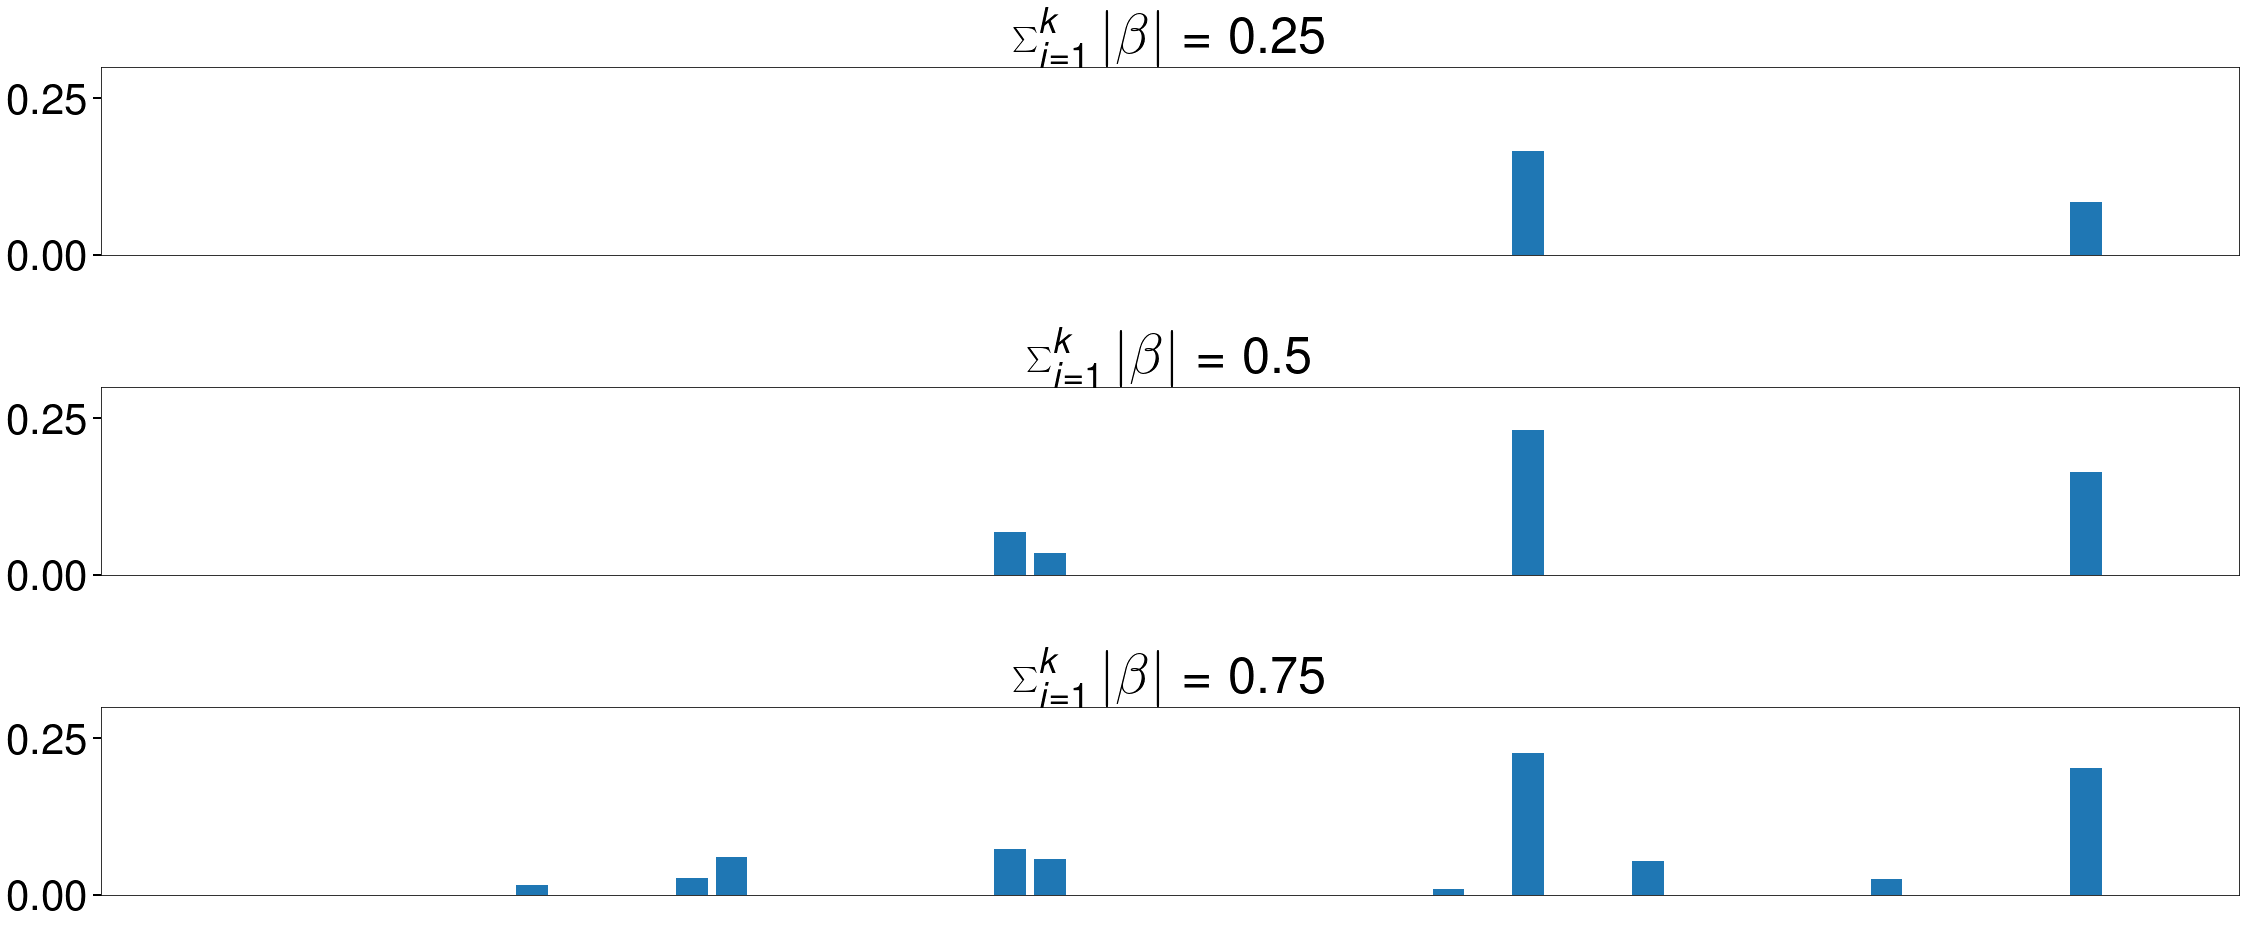

In [23]:
lasso_betas()

# Analysis of Cross-Sectional Data
## Tree-based Estimators

* Regression Tree
* Model Representation
* Pruning
* Bagging and Random Forest
* Boosting

# Regression Trees

* Regression Trees build models with **indicator** variables
* Continuous regressors are transformed into Indicator variables 

$$X_{i,j}\rightarrow I_{\left[X_{i,j}<X_j^\star\right]}$$

* Model is then build using interaction of indicator variables
* Leads to a tree structure where the tree _splits_ on each indicator variable

### Example

* 2-level tree that splits on the market first and then on the return of the size

$$ I_{\left[VWM<0\right]} I_{\left[SMB<1.2\right]} $$

* Parameter estimates are simply averages of $Y_i$ values where indicators are true

$$ \frac{1}{m^\star}\sum_{i=1}^n Y_{i} \left(I_{\left[VWM_i<0\right]} I_{\left[SMB_i<1.2\right]}\right) $$

* $m^\star=\sum_{i=1}^n I_{\left[VWM_i<0\right]} I_{\left[SMB_i<1.2\right]}$ counts the observation in this branch


In [44]:
def show_tree():
    mfe.figsize(y=12)
    fig,ax = plt.subplots(1,1)
    dtr = DecisionTreeRegressor(max_depth=2)
    dtr = dtr.fit(industries, vwm)
    plot_tree(dtr,ax=ax)
    fig.tight_layout(pad=1.0)
    mfe.figsize(y=14)

# Regression Trees
## Two level depiction

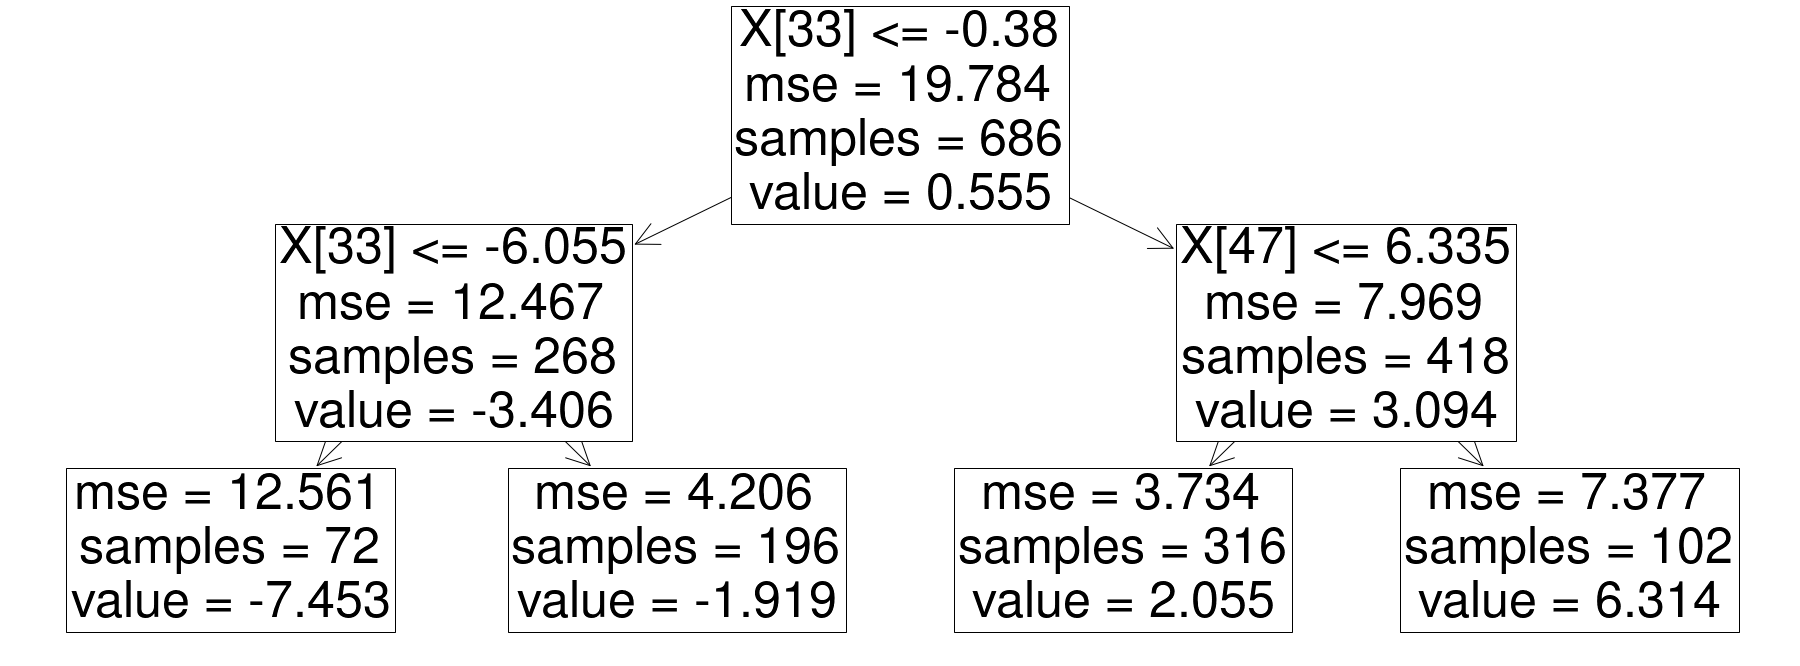

In [43]:
show_tree()

# Regression Trees
## Model Representation

* 2-level tree is regression model

$$
\begin{array}{rl} 
VWM_i = & \beta_1 I_{\left[X_{i,33}\leq -0.38\right]}I_{\left[X_{i,33}\leq -6.055\right]}  \\
+ & \beta_2 I_{\left[X_{i,33}\leq -0.38\right]}I_{\left[X_{i,33}> -6.055\right]} \\
+ & \beta_3 I_{\left[X_{i,33}> -0.38\right]}I_{\left[X_{i,47}\leq 6.335\right]}  \\
+ & \beta_4 I_{\left[X_{i,33}> -0.38\right]}I_{\left[X_{i,47}> 6.335\right]} \\
+ & \epsilon_i  
\end{array}
$$


# Regression Trees
## Key Parameters

Optimize by choosing one of more of:

* Max depth
* Maximum number of nodes
* Minimum decrease in SSE to add a new node
* Minimum group size to allow further splitting

Optimize choice using cross-validation

# Regression Trees
## Max depth

In [45]:
def depth_cross_val():
    mfe.figsize(y=11)
    fig, ax = plt.subplots(1, 1)
    n = vwm.shape[0]
    depth_cv = {}
    for depth in np.arange(1, 30):
        dtr = DecisionTreeRegressor(max_depth=depth, random_state=20201111)
        scores = cross_val_score(
            estimator=dtr,
            X=std_industries,
            y=std_vwm,
            n_jobs=-1,
            scoring="neg_mean_squared_error",
            cv=5,
        )
        depth_cv[depth] = -scores.mean() * n
    depth_cv = pd.Series(depth_cv)
    depth_cv.plot(ax=ax, marker="o", markersize=18, linewidth=0)
    ax.set_xticks(depth_cv.index)
    ax.plot(
        depth_cv.idxmin(),
        depth_cv.loc[depth_cv.idxmin()],
        marker="o",
        markersize=36,
        linewidth=0,
        color=mfe.colors[2],
    )
    dtr = DecisionTreeRegressor(max_depth=depth_cv.idxmin(), random_state=20201111)
    dtr.fit(std_industries, std_vwm)
    print(f"Number of leaves: {dtr.tree_.n_leaves}")


def leaves_cross_val():
    mfe.figsize(y=11)
    fig, ax = plt.subplots(1, 1)
    n = vwm.shape[0]
    nodes_cv = {}
    for nodes in np.arange(25, 501, 25):
        dtr = DecisionTreeRegressor(max_leaf_nodes=nodes, random_state=20201111)
        scores = cross_val_score(
            estimator=dtr,
            X=std_industries,
            y=std_vwm,
            n_jobs=-1,
            scoring="neg_mean_squared_error",
        )
        nodes_cv[nodes] = -scores.mean() * n
    nodes_cv = pd.Series(nodes_cv)
    nodes_cv.plot(ax=ax, marker="o", markersize=18, linewidth=0)
    ax.set_xticks(nodes_cv.index)
    ax.set_xticklabels(np.asarray(nodes_cv.index))
    ax.plot(
        nodes_cv.idxmin(),
        nodes_cv.loc[nodes_cv.idxmin()],
        marker="o",
        markersize=36,
        linewidth=0,
        color=mfe.colors[2],
    )
    dtr = DecisionTreeRegressor(max_leaf_nodes=nodes_cv.idxmin(), random_state=20201111)
    dtr.fit(std_industries, std_vwm)
    print(f"Maximum Depth: {dtr.tree_.max_depth}")


Number of leaves: 640


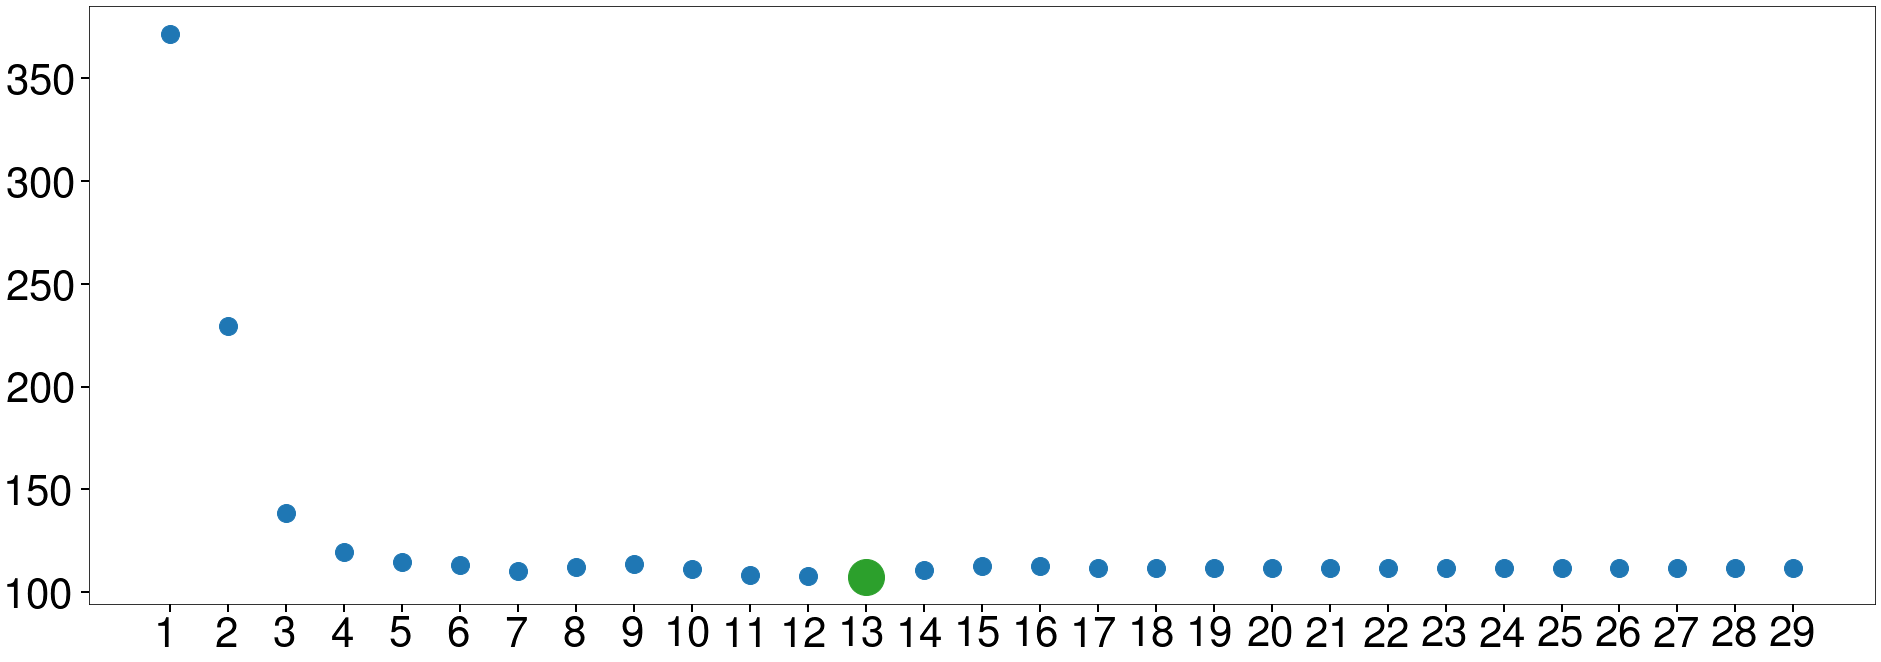

In [46]:
depth_cross_val()

# Regression Trees
## Max nodes

Maximum Depth: 8


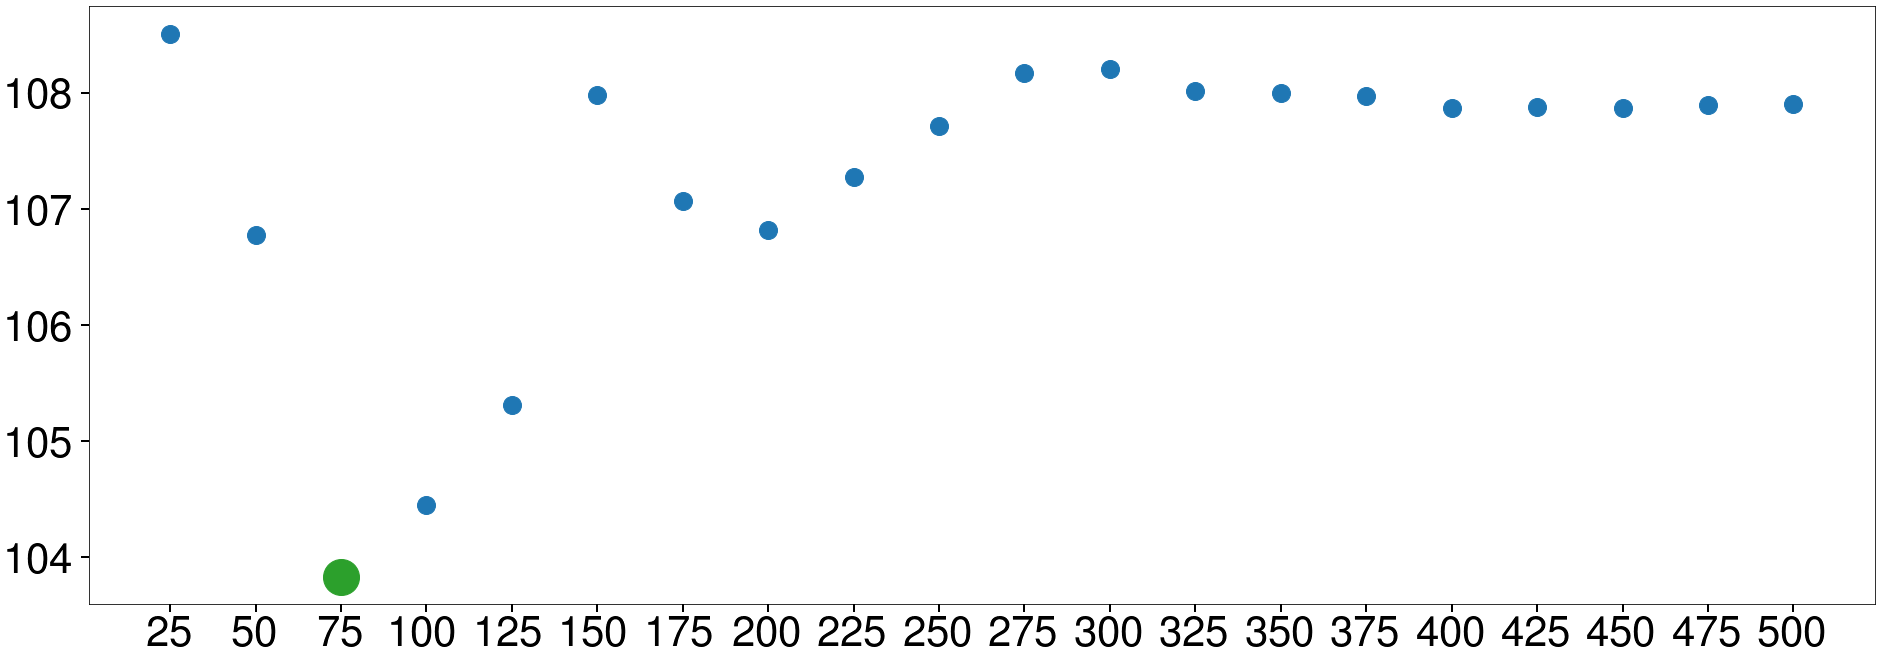

In [47]:
leaves_cross_val()

# Pruning

* Pruning can improve trees by removing nodes that make small improvement to the SSE
* Solve a modified objective function
$$\sum_{i=1}^{n}\left(Y_{i}-\hat{Y_{i}}\right)^{2}+\alpha\left|T\right|$$
    * $\alpha$ is a tuning parameter
    * $|T|$ is the number of terminal nodes
* Larger values of $\alpha$ reduce tree size
* Select $\alpha$ using cross-validation by pruning a large tree for different values of $\alpha$

In [29]:
def plot_tree_depth():
    dtr = DecisionTreeRegressor(random_state=20201111)
    path = dtr.cost_complexity_pruning_path(std_industries, std_vwm)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities
    clfs = []
    for ccp_alpha in ccp_alphas:
        clf = DecisionTreeRegressor(random_state=20201111, ccp_alpha=ccp_alpha)
        clf.fit(std_industries, std_vwm)
        clfs.append(clf)
    clfs = clfs[:-1]
    ccp_alphas = ccp_alphas[:-1]

    node_counts = [clf.tree_.node_count for clf in clfs]
    depth = [clf.tree_.max_depth for clf in clfs]
    fig, ax = plt.subplots(1, 1)
    ax.plot(ccp_alphas, depth, marker="o", drawstyle="steps-post", markersize=18)
    ax.set_xlabel(r"$\alpha$")
    ax.set_ylabel("Depth of tree")
    fig.tight_layout(pad=1.0)
mfe.figsize(y=14)    

# $\alpha$ and tree depth

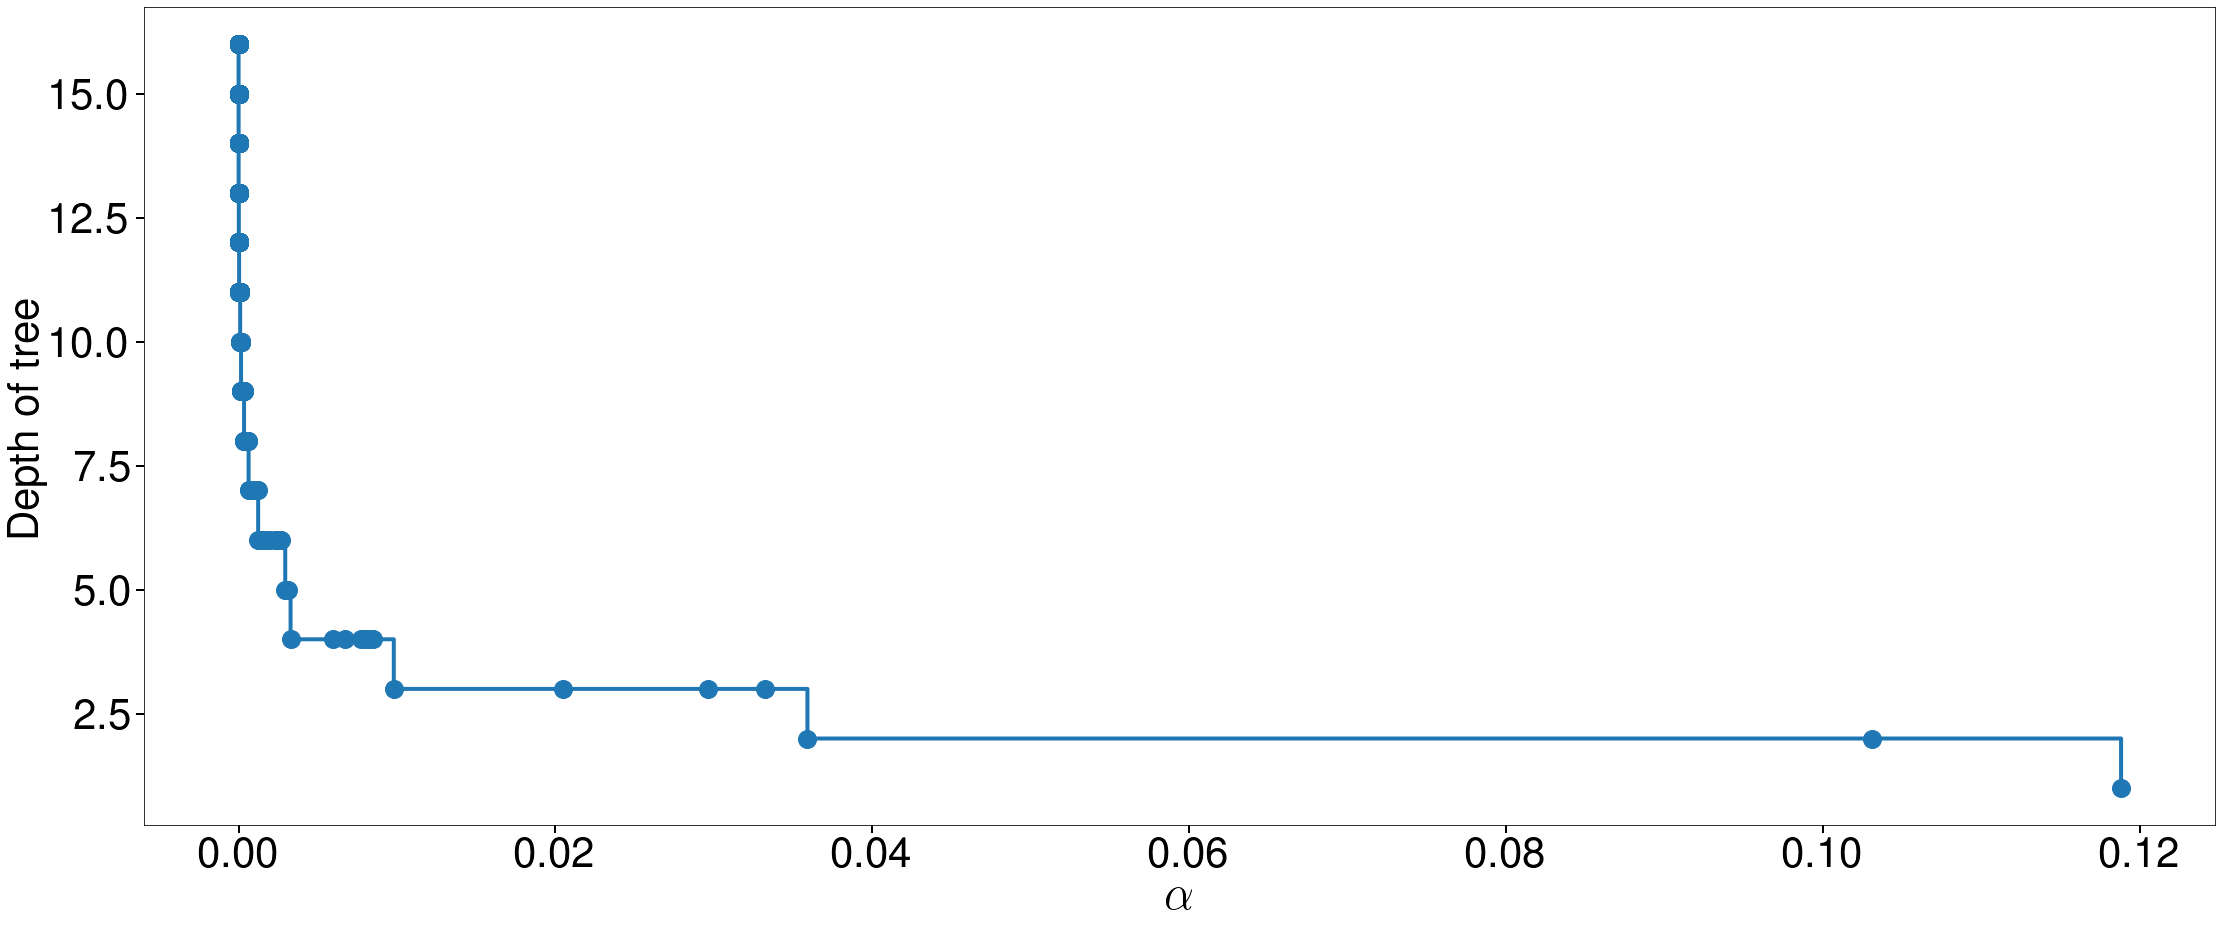

In [30]:
plot_tree_depth()

In [31]:
def pruning_cross_val():
    fig, ax = plt.subplots(1, 1)
    cv_alphas = {}
    dtr = DecisionTreeRegressor(random_state=20201111)
    path = dtr.cost_complexity_pruning_path(std_industries, std_vwm)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities
    n = vwm.shape[0]
    for alpha in ccp_alphas[5::20]:
        dtr = DecisionTreeRegressor(ccp_alpha=alpha, random_state=20201111)
        scores = cross_val_score(
            estimator=dtr,
            X=std_industries,
            y=std_vwm,
            n_jobs=-1,
            scoring="neg_mean_squared_error",
        )
        cv_alphas[alpha] = -scores.mean() * n
    cv_alphas = pd.Series(cv_alphas)
    cv_alphas = cv_alphas.loc[cv_alphas < 1.1 * cv_alphas.min()]
    cv_alphas.plot(ax=ax, marker="o", markersize=18, linewidth=0)
    ax.set_xticks(cv_alphas.index)
    ax.set_xticklabels(np.asarray(cv_alphas.index))
    ax.plot(
        cv_alphas.idxmin(),
        cv_alphas.loc[cv_alphas.idxmin()],
        marker="o",
        markersize=36,
        linewidth=0,
        color=mfe.colors[2],
    )
    ticks = [cv_alphas.index[0], cv_alphas.idxmin(), cv_alphas.index[-1]]
    ax.set_xticks(ticks)
    ax.set_xticklabels([f"{t:0.3g}" for t in ticks])
    dtr = DecisionTreeRegressor(random_state=20201111, ccp_alpha=cv_alphas.idxmin())
    dtr.fit(std_industries, std_vwm)
    print(f"Number of leaves: {dtr.tree_.n_leaves}")
    print(f"Maximum Depth: {dtr.tree_.max_depth}")

mfe.figsize(y=12)    

# Selecting $\alpha$ using cross-validation

Number of leaves: 73
Maximum Depth: 8


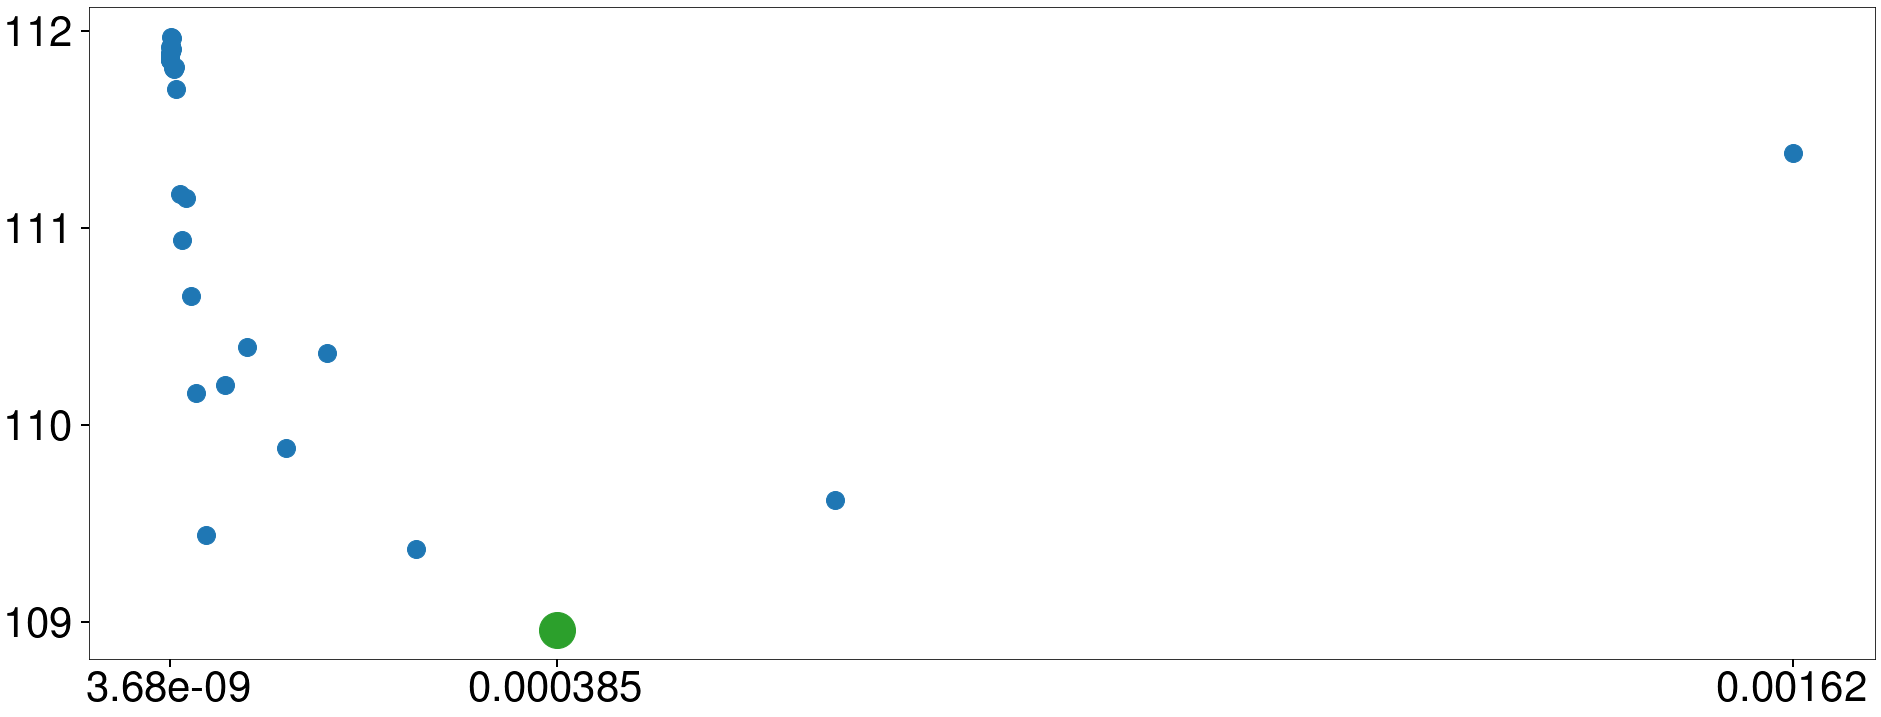

In [32]:
pruning_cross_val()

# Random Forests and Bagging

* Bagging (Bootstrap Aggregation) and Random Forests build $B$ trees using $B$ bootstrapped samples
* Prediction is then
$$ \hat{f}^{\text{RF}}\left(\mathbf{x}_{i}\right)=B^{-1}\sum_{b=1}^{B}\hat{f}^{\left(b\right)}\left(\mathbf{x}_{i}\right) $$

* Random Forest improves on Bagging since:
    * Each tree is built using only $k\approx\sqrt{p}$ of the variables
    * Produces a set of trees that are weekly correlated because most regressors are excluded from each tree
    * Used when two criteria are met
        * p is large
        * A small number of strong predictors
    * **Note**: Bagging is a special case of a Random Forest when $k=p$
* Similar tuning choices as Regression Tree plus $B$ and $k$

In [33]:
rfr = RandomForestRegressor(max_depth=7, max_features="sqrt", random_state=20201111)
rfr = rfr.fit(std_industries, np.squeeze(std_vwm))
err = np.squeeze(std_vwm) - rfr.predict(std_industries)
print((err ** 2).sum())
mfe.figsize(y=14)

10.787708823339596


In [34]:
def rf_nodes_cross_val(max_features):
    nodes_cv = {}

    for nodes in np.arange(25, 501, 25):
        rfr = RandomForestRegressor(
            max_leaf_nodes=nodes,
            random_state=20201111,
            max_features=max_features,  # "auto"#"sqrt"
        )
        scores = cross_val_score(
            estimator=rfr,
            X=std_industries,
            y=std_vwm,
            n_jobs=-1,
            scoring="neg_mean_squared_error",
        )
        nodes_cv[nodes] = -scores.mean() * vwm.shape[0]
    nodes_cv = pd.Series(nodes_cv)
    fix, ax = plt.subplots(1, 1)
    nodes_cv.plot(ax=ax, marker="o", markersize=18, linewidth=0)
    ax.set_xticks(nodes_cv.index)
    ax.set_xticklabels(np.asarray(nodes_cv.index))
    ax.plot(
        nodes_cv.idxmin(),
        nodes_cv.loc[nodes_cv.idxmin()],
        marker="o",
        markersize=36,
        linewidth=0,
        color=mfe.colors[2],
    )

# Random Forest cross-validation

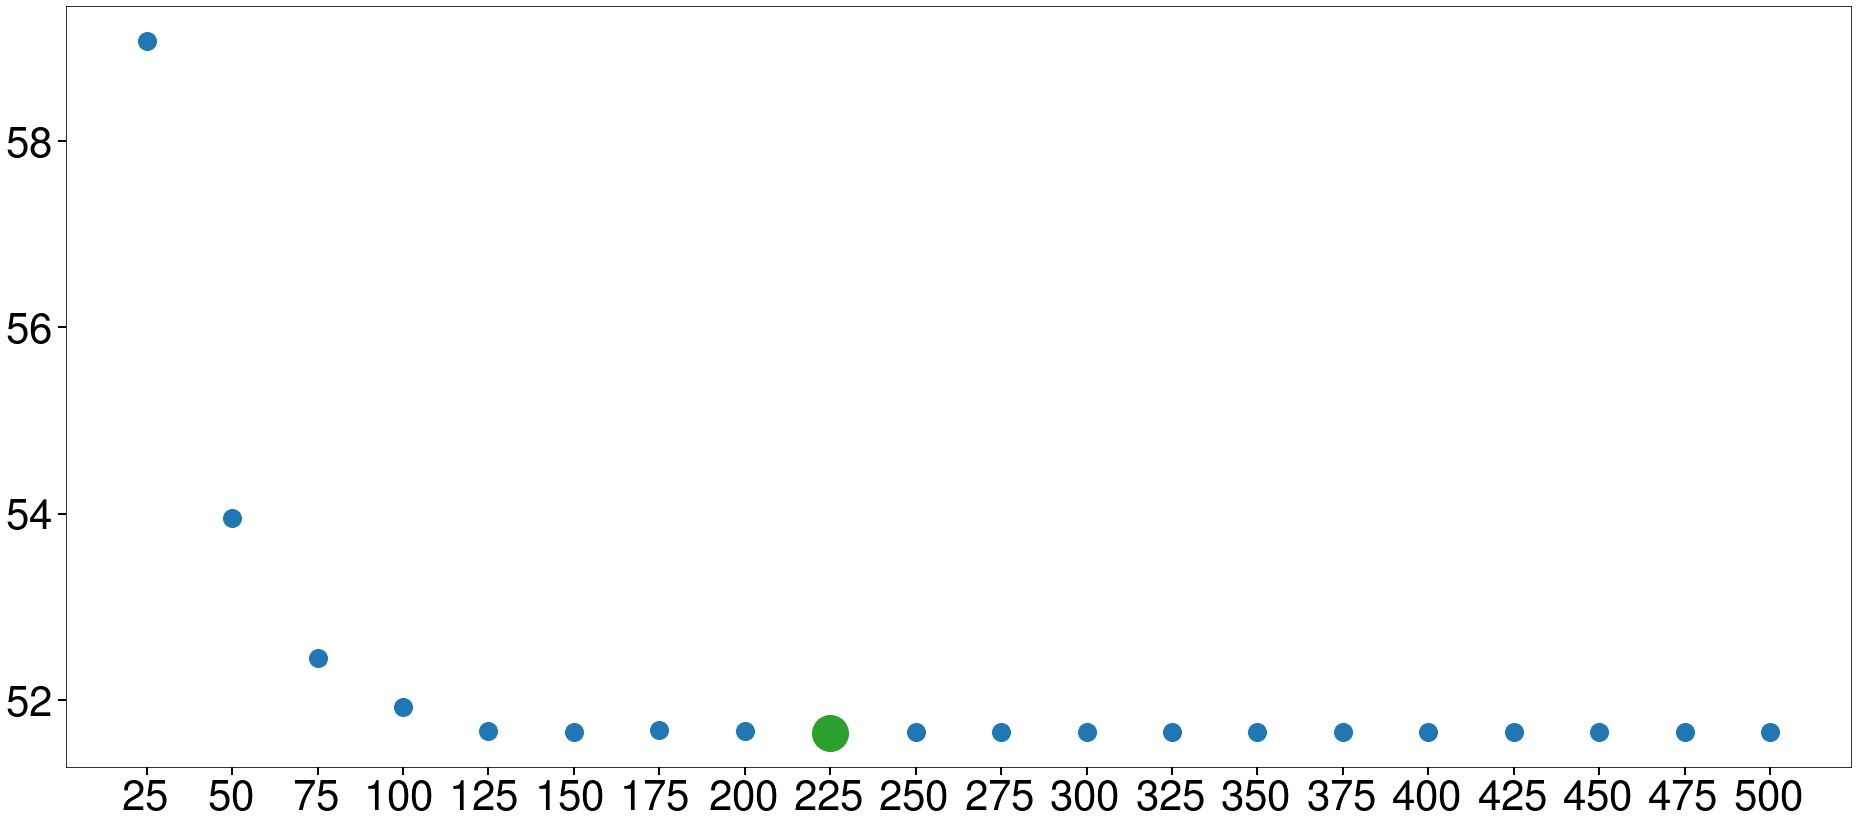

In [35]:
rf_nodes_cross_val("sqrt")

# Bagging cross-validation

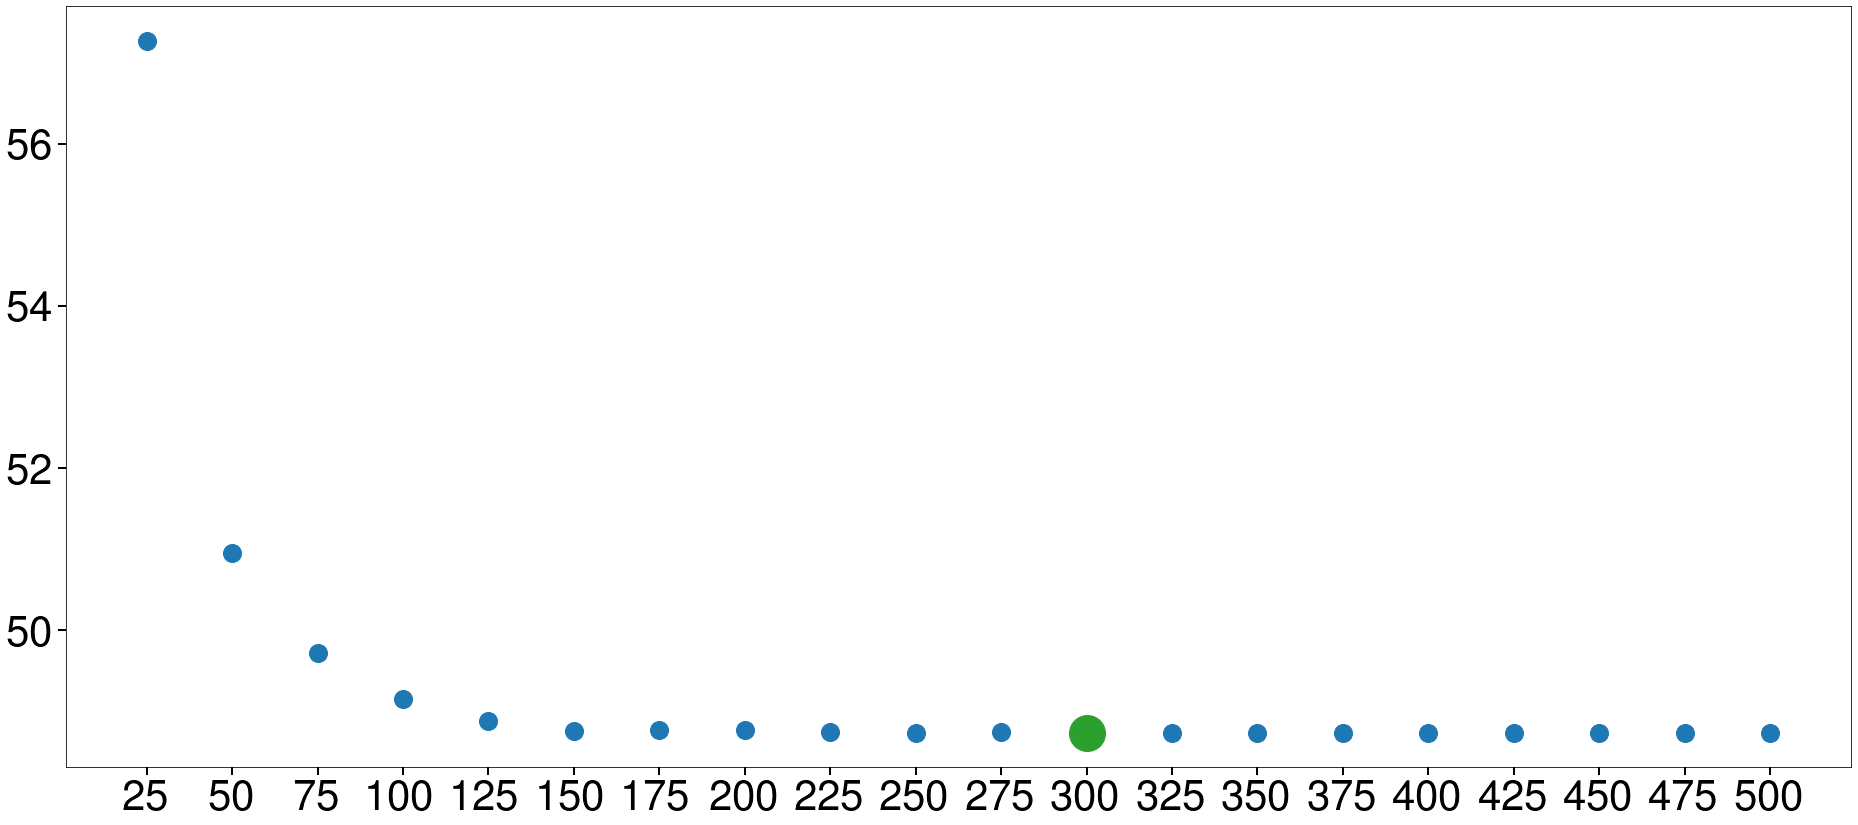

In [36]:
rf_nodes_cross_val("auto")

# Boosting

* Boosting fits a sequence of trees each with a small number $d$ terminal nodes
* Each tree is fit to the residuals of the previous tree
    * Child trees focus on fitting observations that were hard to fit by previous trees
    * Nodes are not added for observations that have small prediction errors 
    * Building a fresh tree collects all observations in to a single leaf
* Builds models with low-interaction terms 
* In a nutshell: build $B$ (large) depth $d$ (small) trees sequentially
* One additional parameter $\lambda$ (small) the slows learning
$$\hat{f}\left(\mathbf{x}\right)=\sum_{b=1}^{B}\lambda\hat{f}^{\left(b\right)}\left(\mathbf{x}\right)$$
* $\hat{f}^{\left(b\right)}$ is the prediction of the residuals produced using the previous $b-1$ trees
$$\hat{\epsilon}^{(b)}_i=\sum_{i=1}^{b-1}Y_i - \lambda\hat{f}^{\left(i\right)}\left(\mathbf{x}\right)$$
* Three tuning parameters: $B$, $d$ and $\lambda$

In [37]:
FORCE = False
if not os.path.exists("grid-search.pkl") or FORCE:

    param_grid = {
        "random_state": [20201111],
        "learning_rate": [0.001, 0.01, 0.025, 0.2],
        "n_estimators": [1000, 2000, 4000, 8000],
        "max_leaf_nodes": [2, 6, 12],
    }

    gbr = GradientBoostingRegressor()
    grid_search = GridSearchCV(
        estimator=gbr,
        param_grid=param_grid,
        verbose=1,
        n_jobs=12,
        scoring="neg_mean_squared_error",
    )
    grid_search.fit(std_industries, std_vwm)
    with open("grid-search.pkl", "wb") as pkl:
        pickle.dump(grid_search, pkl)
else:
    with open("grid-search.pkl", "rb") as pkl:
        grid_search = pickle.load(pkl)

In [38]:
df = pd.DataFrame([pd.Series(p) for p in grid_search.cv_results_["params"]])
df["score"] = grid_search.cv_results_["mean_test_score"]
temp = df.set_index(["learning_rate", "max_leaf_nodes", "n_estimators"])
temp = -temp.score * vwm.shape[0]
temp.index.names = ["Learning Rate", "d", "N Estimators"]


def boosting_cv():
    fig, ax = plt.subplots(3, 1)
    markers = ["v", "s", "^"]
    for i, learning_rate in enumerate((0.001, 0.025, 0.2)):
        for di, depth in enumerate((2, 6, 12)):
            temp2 = temp.loc[(learning_rate, depth)].copy()
            temp2.index = np.arange(1, 5)
            label = None
            if i == 0:
                label = f"$d={int(depth)}$"
            temp2.plot(
                ax=ax[i], marker=markers[di], markersize=24, linewidth=0, label=label
            )
        ax[i].set_title(f"$\lambda={learning_rate:0.3f}$")
        ax[i].set_xticks([1, 2, 3, 4])
        if i == 0:
            ax[i].legend(frameon=False, ncol=3)
        if i == 2:
            ax[i].set_xticklabels([1000, 2000, 4000, 8000])
            ax[i].set_xlabel("$B$")
        else:
            ax[i].set_xticklabels([])
    fig.tight_layout(pad=1.0)

# Cross-validating Boosted Trees

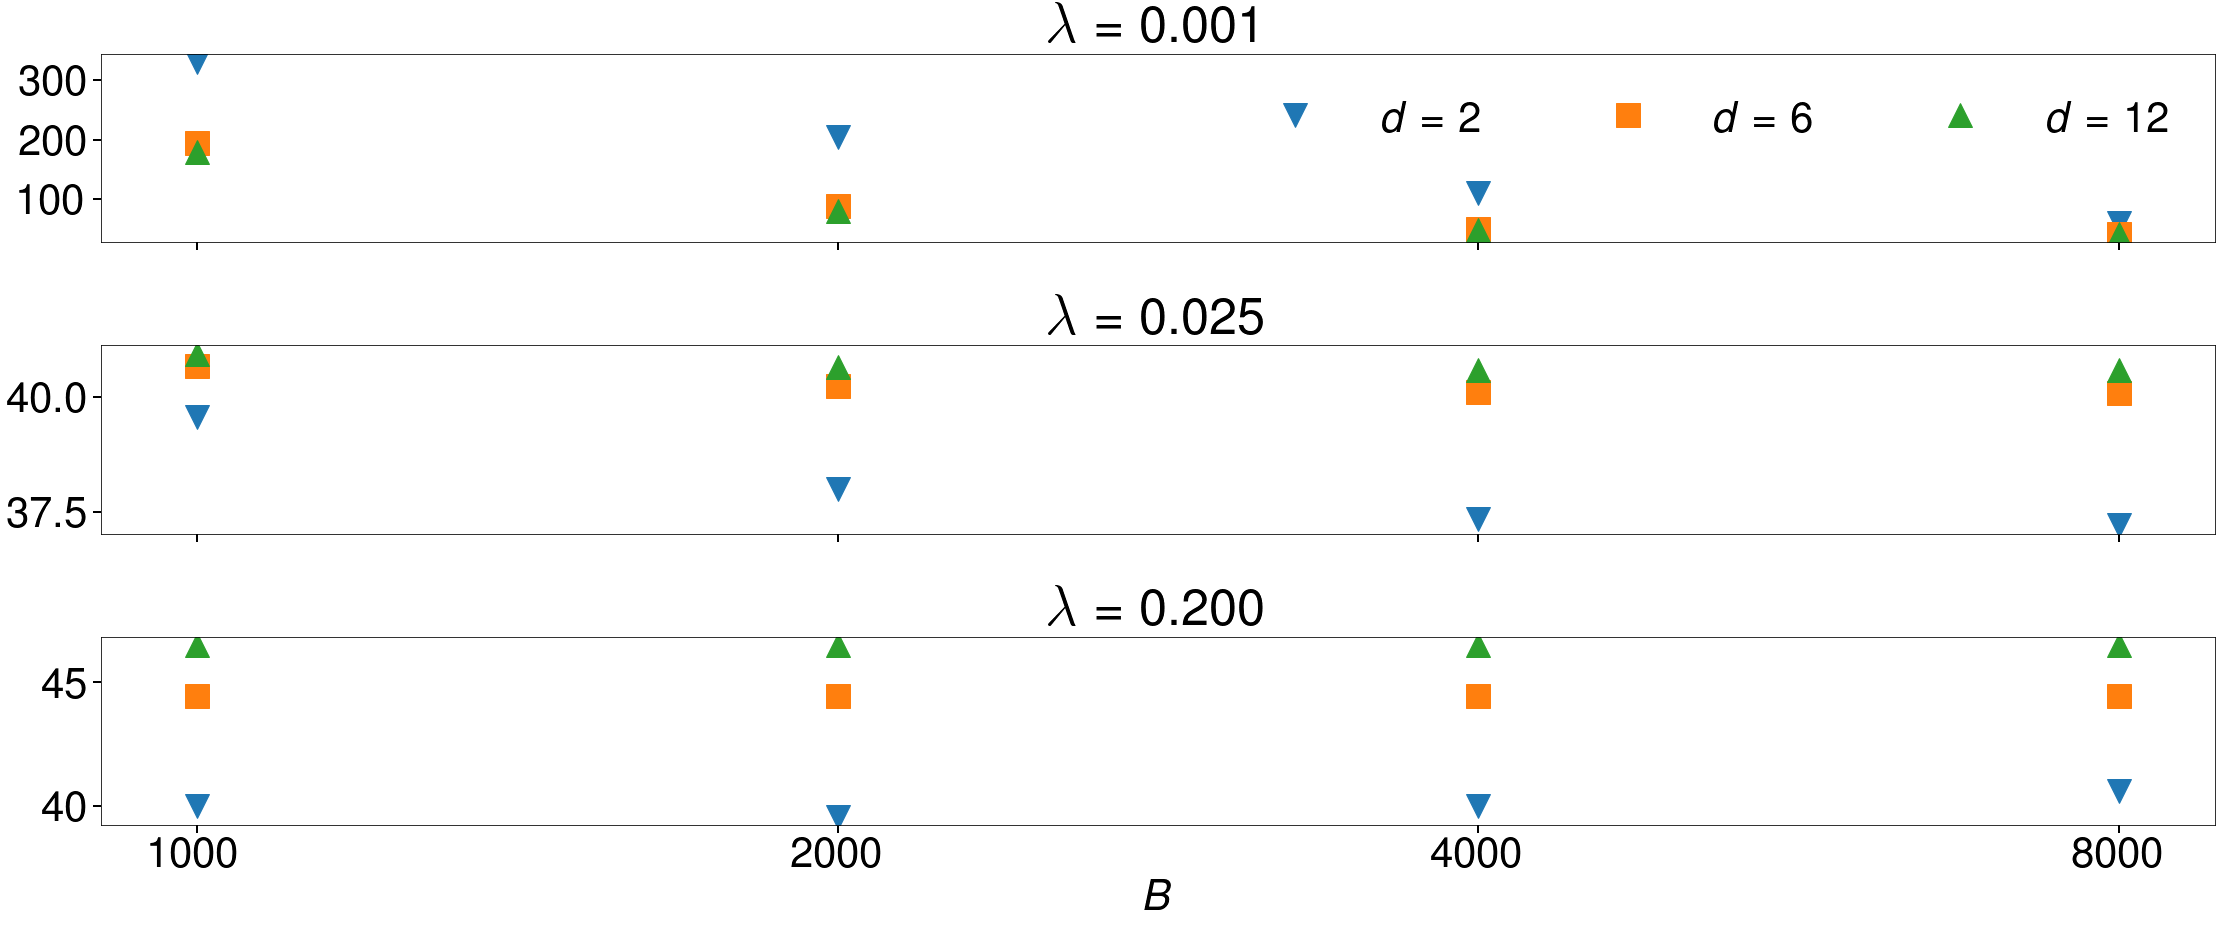

In [39]:
boosting_cv()